# Customer Churn

Colonne:
- **CustomerID**
- **Count**
- **Country**: United States
- **State**: California
- **City**
- **Zip Code**: codici postali
- **Lat Long**: latitudine, longitudine
- **Latitude**
- **Longitude**
- **Gender**
- **Senior Citizen**: cliente anziano oppure no
- **Partner**: cliente con partner oppure no
- **Dependents**: se è un dipendente o meno
- **Tenure Months**: mesi di permanenza
- **Phone Service**
- **Multiple Lines**
- **Internet Service**
- **Online Security**
- **Online Backup**
- **Device Protection**
- **Tech Support**
- **Streaming TV**
- **Streaming Movies**
- **Contract**: Tipologia di contratto affiliato al cliente
- **Paperless Billing**: fatturazione non cartacea
- **Payment Method**: Metodo di pagamento utilizzato dal cliente
- **Monthly Charges**: spese mensili
- **Total Charges**: spese totali
- **Churn Label**: YES ( chi ha abbandonato definitivamente) e NO ( chi non ha ancora abbandonato)
- **Churn Value**: è la colonna "Churn Label" codificata
- **Churn Score**: stima lo stato di abbandono per un determinato utente in un dato momento ([0, 0.50] = punteggio di abbandono basso, stato: *attivo*; [0.51, 0.69] = punteggio di abbandono medio, stato: *in calo*; [0.70, 1.00] = punteggio di abbandono alto, stato: *allerta abbandono*)
- **CLTV**: *Customer Lifetime Value* = metrica che misura i profitti prevedibili in base alla relazione con il cliente. Si considerano i comportamenti d'acquisto del cliente e sulla base di questi si effettuano delle previsioni sulla loro profittabilità nel lungo periodo. In altre parole, l'indicatore CLTV rappresenta il ricavo che avremo da un cliente in tutto il tempo che resterà tale.
- **Churn Reason**: ragioni che hanno portato il cliente ad abbandonare il servizio.

# executive summary

L'obbiettivo è capire se esistono correlazioni tra l'abbando dell'azienda o il restare a farne parte, usufruendo dei servizi.
L'azienda vuole sicuramente capire come aumentare la `fidelizzazione` dei suoi clienti compensando eventuali falle. 

**customer Churn:**
La *customer churn* è una metrica espressa in percentuale che rappresenta la quantità dei clienti che hanno smesso di fare affari con un'azienda durante un determinato periodo di tempo. Questo valore si ottiene dividendo il numero di clienti che hanno terminato la loro relazione commerciale con l'azienda nel periodo specifico, per il numero totale di clienti che l'azienda aveva all'inizio di tale periodo.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit, StratifiedKFold, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import metrics
from sklearn.metrics import f1_score, accuracy_score, recall_score, confusion_matrix, classification_report, precision_recall_curve, auc, ConfusionMatrixDisplay
import tensorflow as tf

from rich.console import Console
from rich import print
from rich.style import Style


%matplotlib inline

In [2]:
plt.rcParams['figure.dpi'] = 125
plt.rcParams['font.family'] = "Times New Roman"
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['text.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['axes.facecolor'] = 'whitesmoke'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['figure.facecolor'] = 'whitesmoke'

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [4]:
df = pd.read_csv("Telco_customer_churn.csv")
df.head(3)

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,No,No,Yes,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved


# Data Preprocessing

In [5]:
# Cambio il Data Type della colonna `Total Charges` per farlo essere un valore Numerico
df['Total Charges'] = pd.to_numeric(df['Total Charges'], errors='coerce', downcast='float')

In [6]:
# Controllo che i valori Null e mostro solo quelli con un valore maggiore di 0
a = df.isnull().sum()
a[a>0]

Total Charges      11
Churn Reason     5174
dtype: int64

Durante la conversione in valore numerico, 11 valori sono diventati NaN, mi salvo un dataframe 
e inizio a capire se posso fare qualcosa per non dover eliminare i risultati.

In [7]:
nan = df[df['Total Charges'].isna()]
nan[['Tenure Months','Total Charges','Churn Reason','Churn Label']]

,Tenure Months,Total Charges,Churn Reason,Churn Label
2234,0,NaN,NaN,No
2438,0,NaN,NaN,No
2568,0,NaN,NaN,No
2667,0,NaN,NaN,No
2856,0,NaN,NaN,No
4331,0,NaN,NaN,No
4687,0,NaN,NaN,No
5104,0,NaN,NaN,No
5719,0,NaN,NaN,No
6772,0,NaN,NaN,No


In [9]:
# Tenure Months -> mesi di permanenza
nan['Tenure Months'].unique()

array([0], dtype=int64)

In [10]:
nan['Churn Label'].unique()

array(['No'], dtype=object)

Dalle ultime righe di codice posso intuire che la `Churn Reason` non è presente perchè il cliente non ha semplicemente abbandonato l'azienda.

Per quanto riguarda `Tenure Months` si nota come il cliente ha appena iniziato a far parte dell'azienda quindi non può avere una `Total Charges`,

dato questo fatto evidente provvedo a sostituire il valore `NaN` in `Total Charges` con `0`.

In [6]:
df['Total Charges'] = df['Total Charges'].fillna(0)

In [7]:
df['Churn Reason'] = df['Churn Reason'].fillna('Active Member')  # ACHTHUNG!!

**ACHTHUNG:** Ho sostituito il valore `NaN` in `Churn Reason` con `Active Member`, in caso si volesse condurre uno studio sulle motivazioni si dovrà salvare
separatamente un dataframe con i soli clienti che hanno lasciato l'azienda.

In [10]:
# Controllo i valori Null
a = df.isnull().sum()
a[a>0]

Series([], dtype: int64)

# EDA

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   object 
 1   Count              7043 non-null   int64  
 2   Country            7043 non-null   object 
 3   State              7043 non-null   object 
 4   City               7043 non-null   object 
 5   Zip Code           7043 non-null   int64  
 6   Lat Long           7043 non-null   object 
 7   Latitude           7043 non-null   float64
 8   Longitude          7043 non-null   float64
 9   Gender             7043 non-null   object 
 10  Senior Citizen     7043 non-null   object 
 11  Partner            7043 non-null   object 
 12  Dependents         7043 non-null   object 
 13  Tenure Months      7043 non-null   int64  
 14  Phone Service      7043 non-null   object 
 15  Multiple Lines     7043 non-null   object 
 16  Internet Service   7043 

Per prima cosa analizzo le colonne binarie del dataframe 
controllando come sono distribuiti i valori.

In [15]:
for col in df.columns:
    if len(df[col].value_counts()) <= 2:
        print("\n")
        print(col+":")
        print(df[col].value_counts())
    else:
        pass

Count:

1    7043
Name: Count, dtype: int64

Country:

United States    7043
Name: Country, dtype: int64

State:

California    7043
Name: State, dtype: int64

Gender:

Male      3555
Female    3488
Name: Gender, dtype: int64

Senior Citizen:

No     5901
Yes    1142
Name: Senior Citizen, dtype: int64

Partner:

No     3641
Yes    3402
Name: Partner, dtype: int64

Dependents:

No     5416
Yes    1627
Name: Dependents, dtype: int64

Phone Service:

Yes    6361
No      682
Name: Phone Service, dtype: int64

Paperless Billing:

Yes    4171
No     2872
Name: Paperless Billing, dtype: int64

Churn Label:

No     5174
Yes    1869
Name: Churn Label, dtype: int64

Churn Value:

0    5174
1    1869
Name: Churn Value, dtype: int64

0) `Count` riporta solo il valore **1** quindi provvedo a rimuovere questa colonna.

1) `Country` e `State` Riguardano tutti rispettivamente **United States** e **California** quindi eliminerò queste colonne facendo solo un riferimento che tutti i dati
provengono da una azienda che risiede in California.

2) `Churn Value` e `Churn Label` sono il solito dato solo codificato in modo differente --> mappa { No:0 , Yes:1 }

3) Pur non essendo nella lista sovrastante rimuoverò anche la colonna `CustomerID` essendo che per l'analisi non serve al nostro fine.

4) rimuovo anche le colonne `Zip Code`, `longitudine`, `latitudine` e `latlong` salvandole in un Dataframe a Parte -> `geodata`

3) Possiamo notare inoltre, dal valore di `Churn Label` che il dataframe appare sbilanciato per questo motivo ho scelto di dividere i dati con `StratifiedShuffleSplit`
---

---
Controllo le restanti colonne ma che abbiano tra (2, 4] valori.
In questo modo mi faccio un'idea generale della maggior parte del dataframe

In [16]:
for col in df.columns:
    if len(df[col].value_counts()) > 2 and len(df[col].value_counts()) <= 4:
        print("\n")
        print(col+":")
        print(df[col].value_counts())
    else:
        pass

Multiple Lines:

No                  3390
Yes                 2971
No phone service     682
Name: Multiple Lines, dtype: int64

Internet Service:

Fiber optic    3096
DSL            2421
No             1526
Name: Internet Service, dtype: int64

Online Security:

No                     3498
Yes                    2019
No internet service    1526
Name: Online Security, dtype: int64

Online Backup:

No                     3088
Yes                    2429
No internet service    1526
Name: Online Backup, dtype: int64

Device Protection:

No                     3095
Yes                    2422
No internet service    1526
Name: Device Protection, dtype: int64

Tech Support:

No                     3473
Yes                    2044
No internet service    1526
Name: Tech Support, dtype: int64

Streaming TV:

No                     2810
Yes                    2707
No internet service    1526
Name: Streaming TV, dtype: int64

Streaming Movies:

No                     2785
Yes                    2732
No internet service    1526
Name: Streaming Movies, dtype: int64

Contract:

Month-to-month    3875
Two year          1695
One year          1473
Name: Contract, dtype: int64

Payment Method:

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: Payment Method, dtype: int64

## Variabile *target*

Text(0.5, 0, 'Churn')

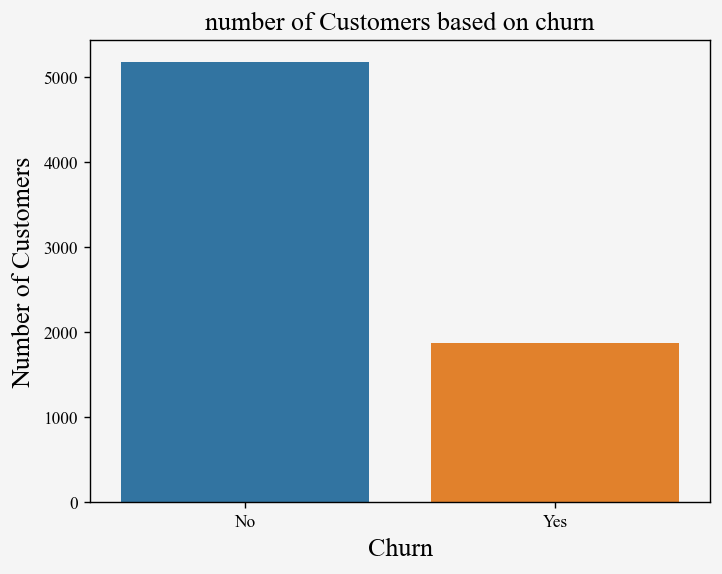

In [17]:
churn = df['Churn Label'].value_counts().reset_index()
sns.barplot(data=churn, x='index', y='Churn Label')
plt.title('number of Customers based on churn')
plt.ylabel('Number of Customers')
plt.xlabel('Churn')

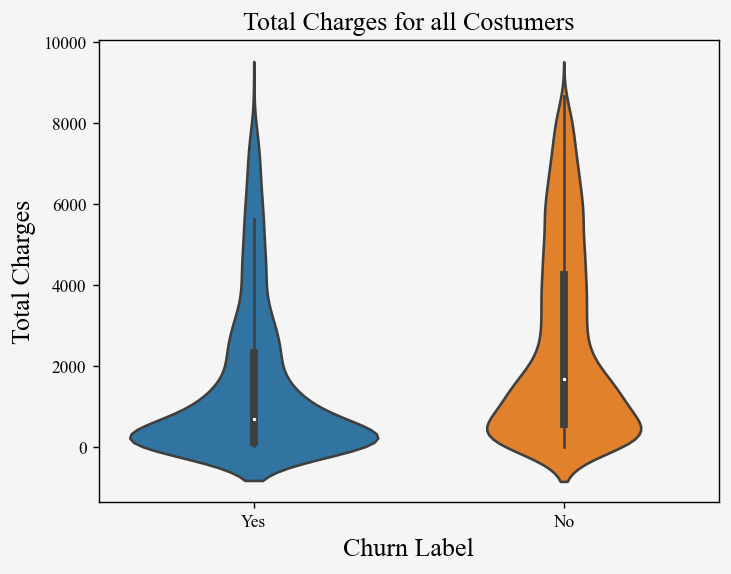

In [11]:
sns.violinplot(data=df,x='Churn Label', y='Total Charges')
plt.title('Total Charges for all Costumers')
plt.show()

## *Contract*

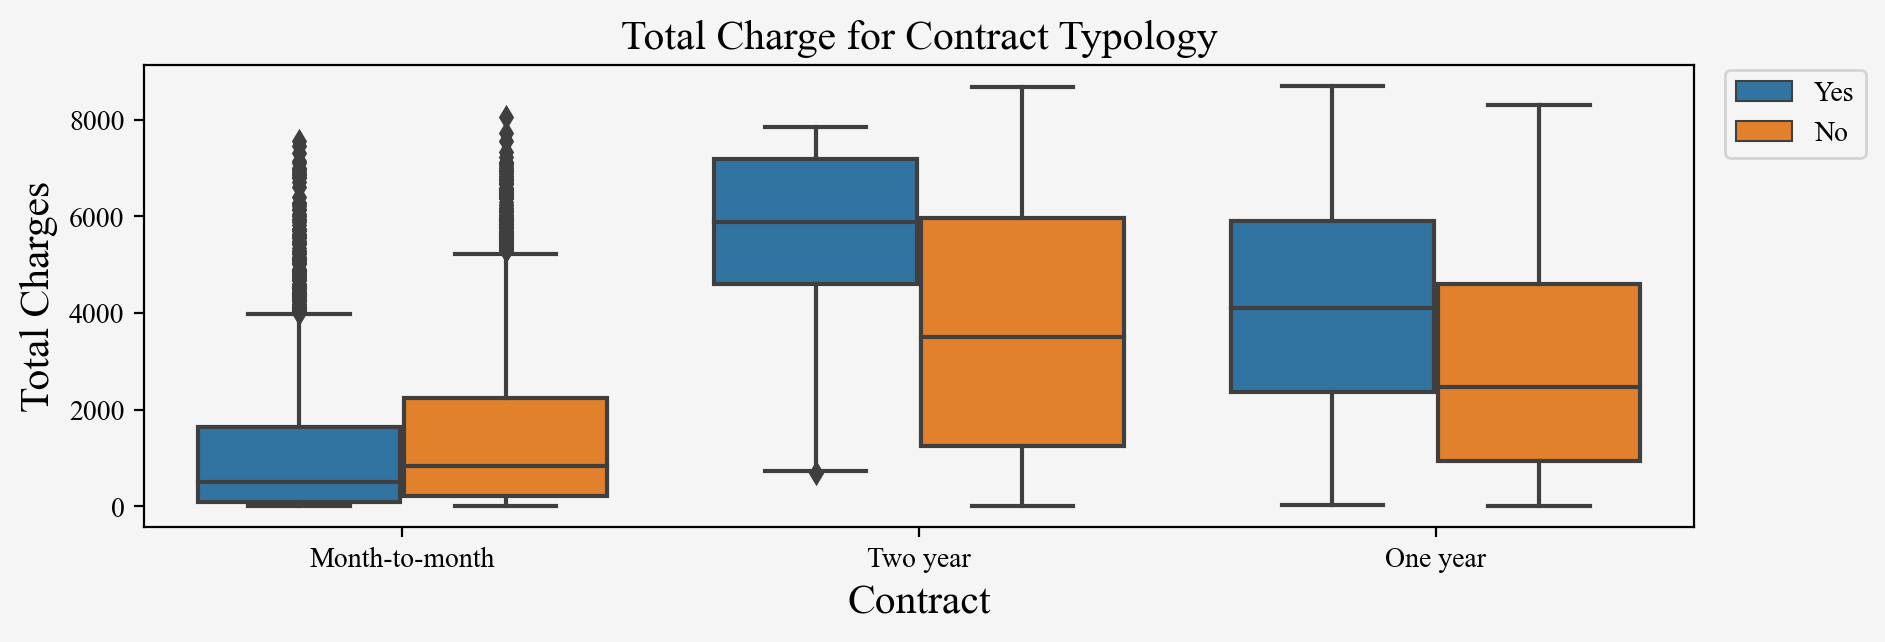

In [19]:
plt.figure(figsize=(10,3),dpi=200)
sns.boxplot(data=df, x='Contract', y='Total Charges', hue='Churn Label')
plt.legend(loc=(1.02,0.8))
plt.title("Total Charge for Contract Typology");

<Figure size 2000x600 with 0 Axes>

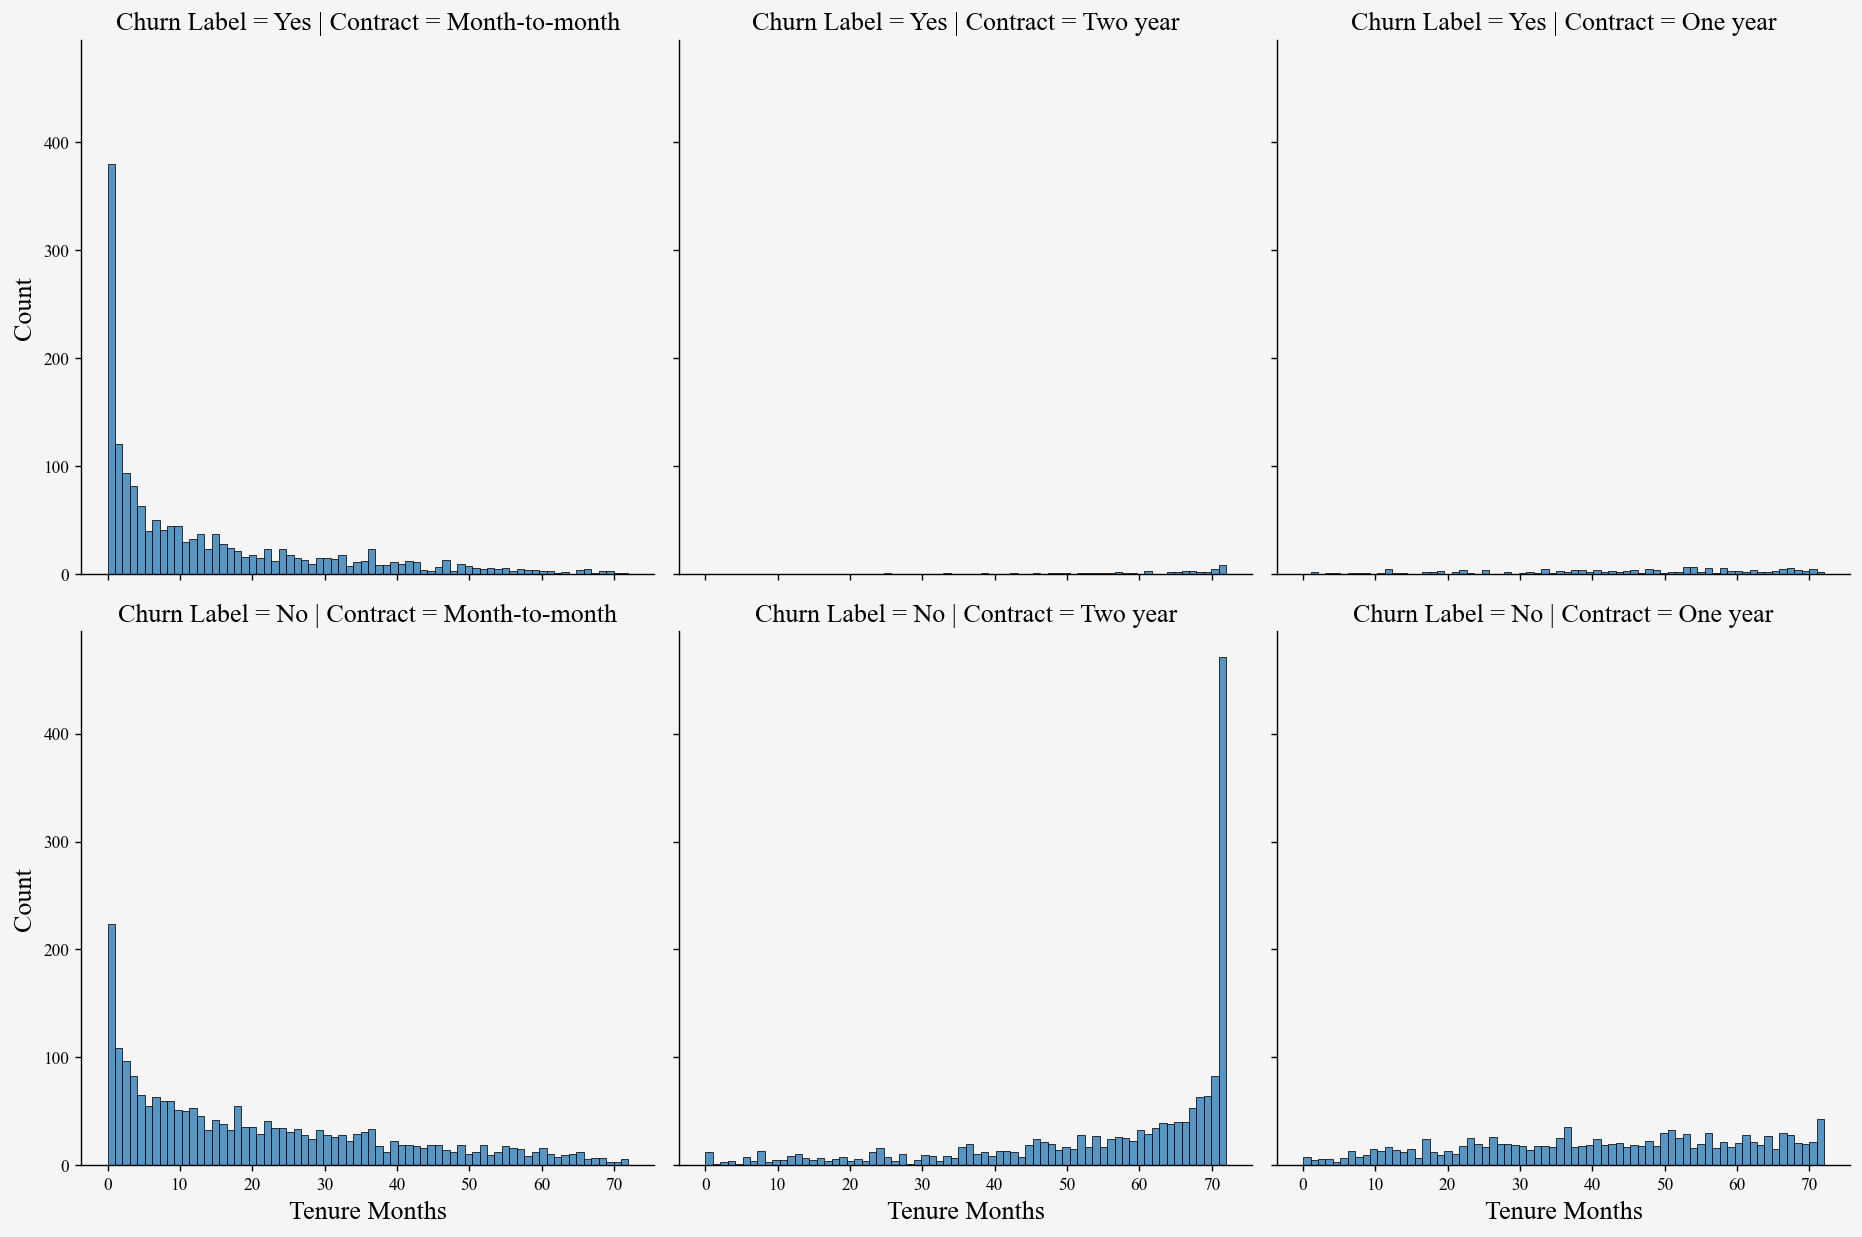

In [17]:
plt.figure(figsize=(10,3),dpi=200)
sns.displot(data=df,x='Tenure Months',bins=70,col='Contract',row='Churn Label')
plt.show()

## *Tenure Months*

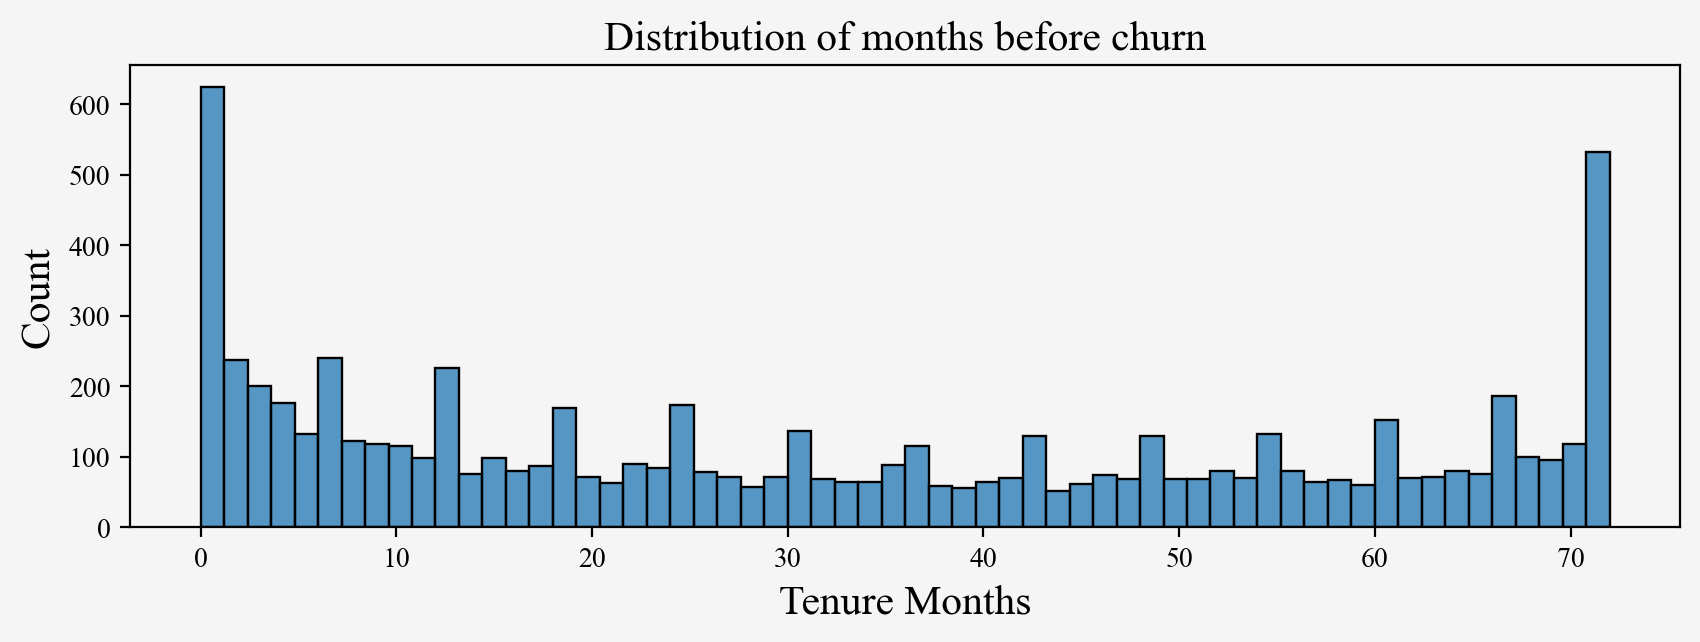

In [20]:
plt.figure(figsize=(10,3),dpi=200)
sns.histplot(data=df,x='Tenure Months',bins=60)
plt.title("Distribution of months before churn");

In [8]:
# len(df['Tenure Months'].unique())

idx = range(1, 73)
for i in idx:
    if i in range(0, 12):
        df.loc[df['Tenure Months'] == i, 'tenure_range'] = '0-12 Months'
    elif i in range(12, 24):
        df.loc[df['Tenure Months'] == i, 'tenure_range'] = '12-24 Months'
    elif i in range(24, 48):
        df.loc[df['Tenure Months'] == i, 'tenure_range'] = '24-48 Months'
    else:
        df.loc[df['Tenure Months'] == i, 'tenure_range'] = 'Over 48 Months'

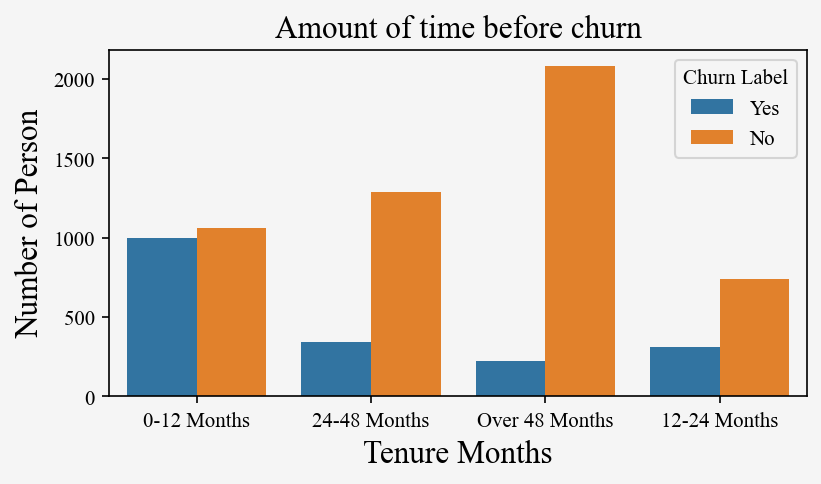

In [20]:
plt.figure(figsize=(6,3), dpi=150)
sns.countplot(data=df, x='tenure_range', hue='Churn Label')
plt.xlabel("Tenure Months")
plt.ylabel("Number of Person")
plt.title("Amount of time before churn")
plt.show()

<Figure size 2000x1200 with 0 Axes>

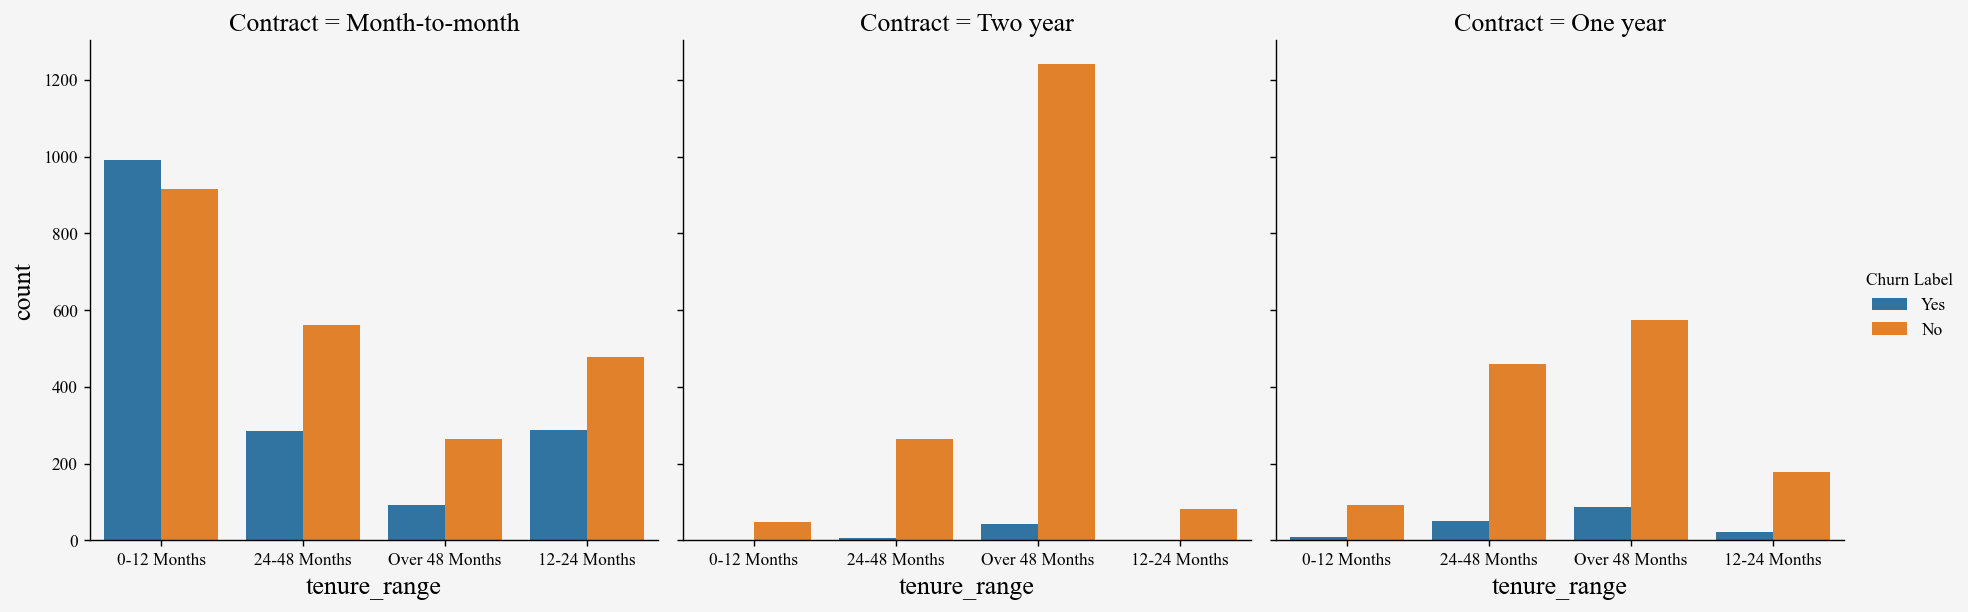

In [29]:
plt.figure(figsize=(10, 6),dpi=200)
sns.catplot(data=df, x='tenure_range', hue='Churn Label', col='Contract', kind='count')
plt.show()

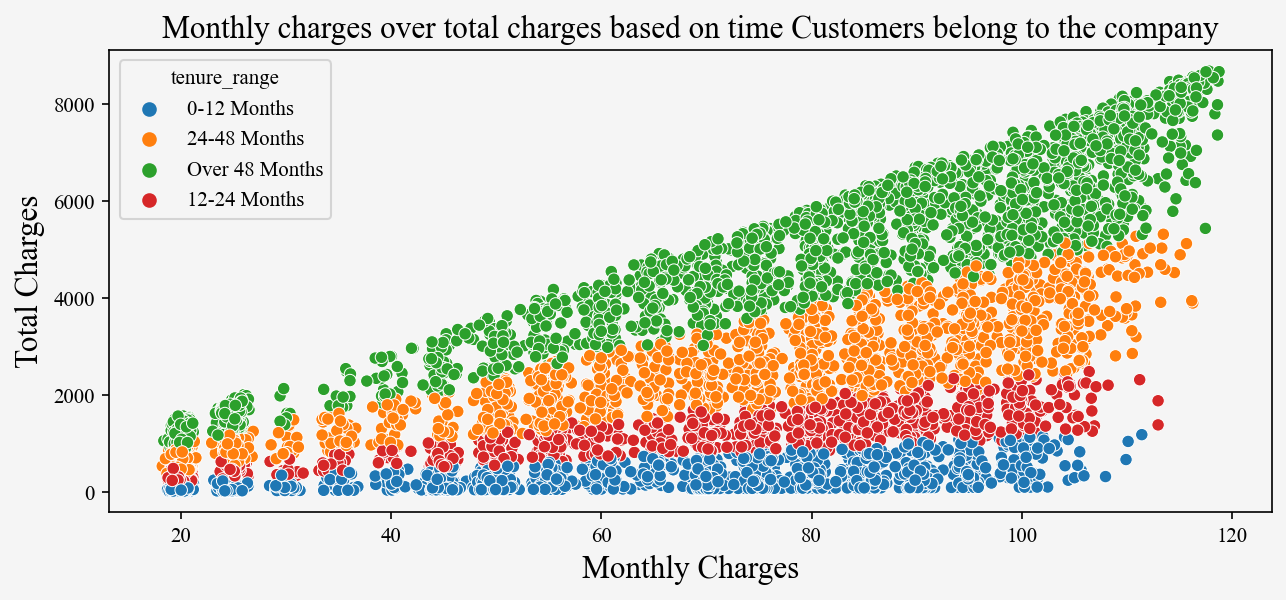

In [22]:
plt.figure(figsize=(10,4), dpi=150)
sns.scatterplot(data=df, x='Monthly Charges', y='Total Charges', hue='tenure_range')
plt.title("Monthly charges over total charges based on time Customers belong to the company")
plt.show()

## Churn Reason

In [9]:
churn_map = {
    'Active Member': 'Active member',
    'Attitude of support person': 'Support person attitude',
    'Competitor offered higher download speeds': 'Higher download speeds',
    'Competitor offered more data': 'More data',
    "Don't know": "Don't know",
    'Competitor made better offer': 'Better offer made',
    'Attitude of service provider': 'Service provider attitude',
    'Competitor had better devices': 'Better devices',
    'Network reliability': 'Network reliability',
    'Product dissatisfaction': 'Product dissatisfaction',
    'Price too high': 'Price too high',
    'Service dissatisfaction': 'Service dissatisfaction',
    'Lack of self-service on Website': 'No self-service on website',
    'Extra data charges': 'Extra data charges',
    'Moved': 'Moved',
    'Lack of affordable download/upload speed': 'Lack of affordable speed',
    'Long distance charges': 'Long distance charges',
    'Limited range of services': 'Limited services range',
    'Poor expertise of phone support': 'Poor phone support expertise',
    'Poor expertise of online support': 'Poor online support expertise',
    'Deceased': 'Deceased'
}

In [10]:
df['Churn Reason'] = df['Churn Reason'].map(churn_map)

In [11]:
Churn_reason = df[df['Churn Reason'] != 'Active member']
churn_motivation = Churn_reason['Churn Reason'].value_counts()
churn_motivation = churn_motivation.reset_index()

In [27]:
churn_motivation.shape[0], len(Churn_reason['Churn Reason'].unique())

(20, 20)

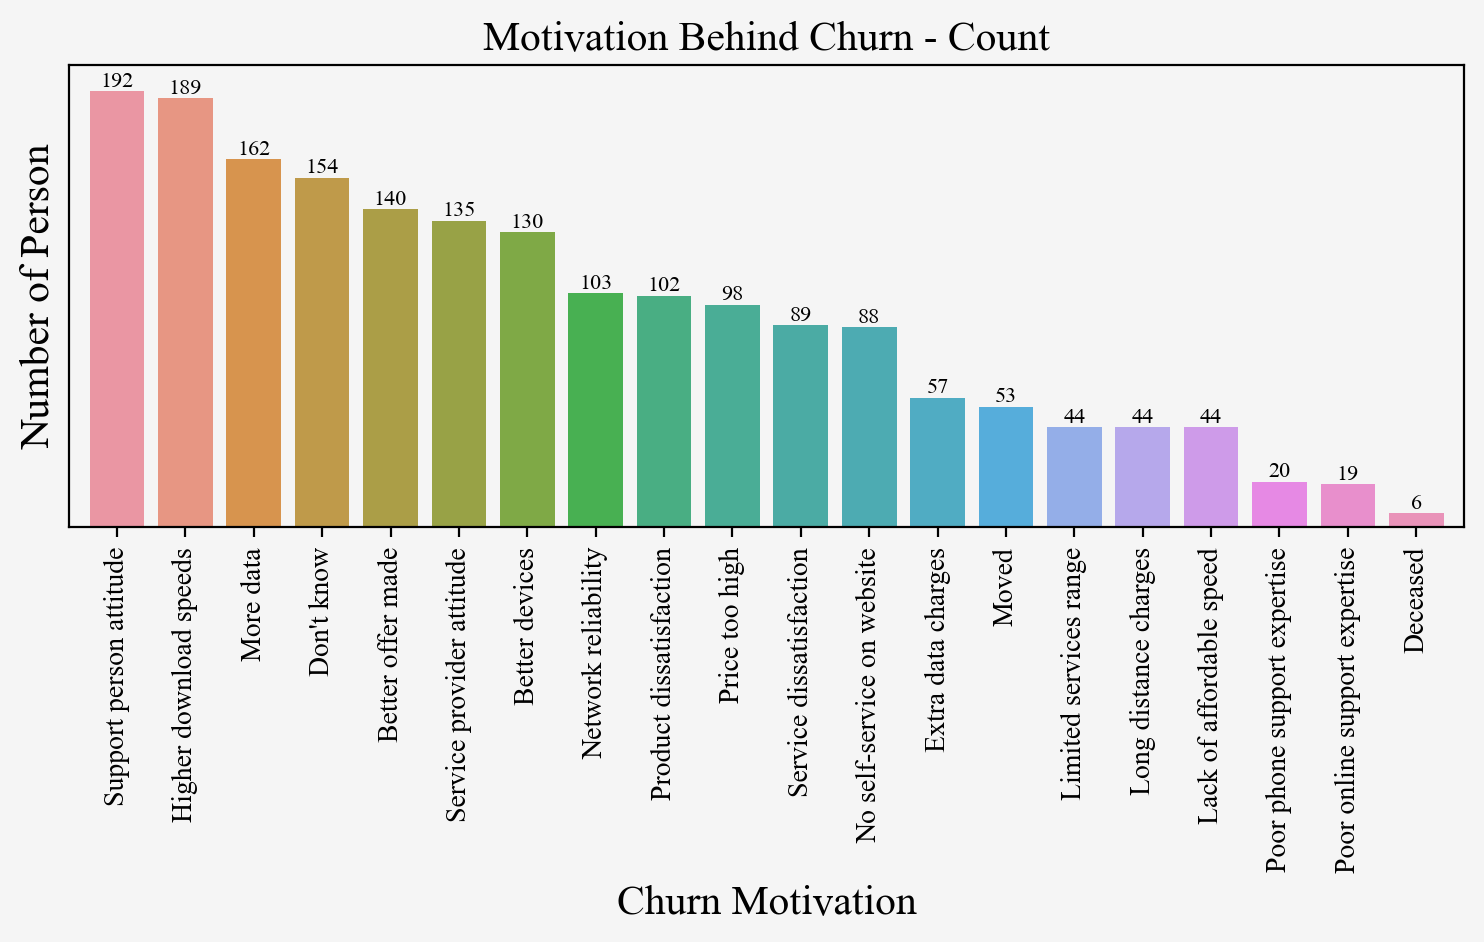

In [28]:
plt.figure(figsize=(9, 3), dpi=200)
ax = sns.barplot(data=churn_motivation, x='index', y='Churn Reason')

for index, value in enumerate(churn_motivation['Churn Reason']):
    ax.text(index, value, str(value), ha='center', va='bottom', fontsize=8)

plt.title("Motivation Behind Churn - Count")
plt.xlabel('Churn Motivation')
plt.ylabel('Number of Person')
plt.yticks([])
plt.xticks(rotation=90)

x_min, x_max = ax.get_xlim()
offset = (x_max - x_min) * 0.01
ax.set_xlim(x_min - offset, x_max + offset)

y_min, y_max = ax.get_ylim()
offset = (y_max - y_min) * 0.01  
ax.set_ylim(y_min, y_max + offset)

plt.show()

In [12]:
def Percentage_Churn(labels):
    _, counts = np.unique(labels, return_counts=True)
    counts = np.sort(counts)[::-1]
    probabilities = counts / len(labels)
    return np.round(probabilities,2)

In [13]:
churn_motivation['Percentage_Churn'] = Percentage_Churn(Churn_reason['Churn Reason'])

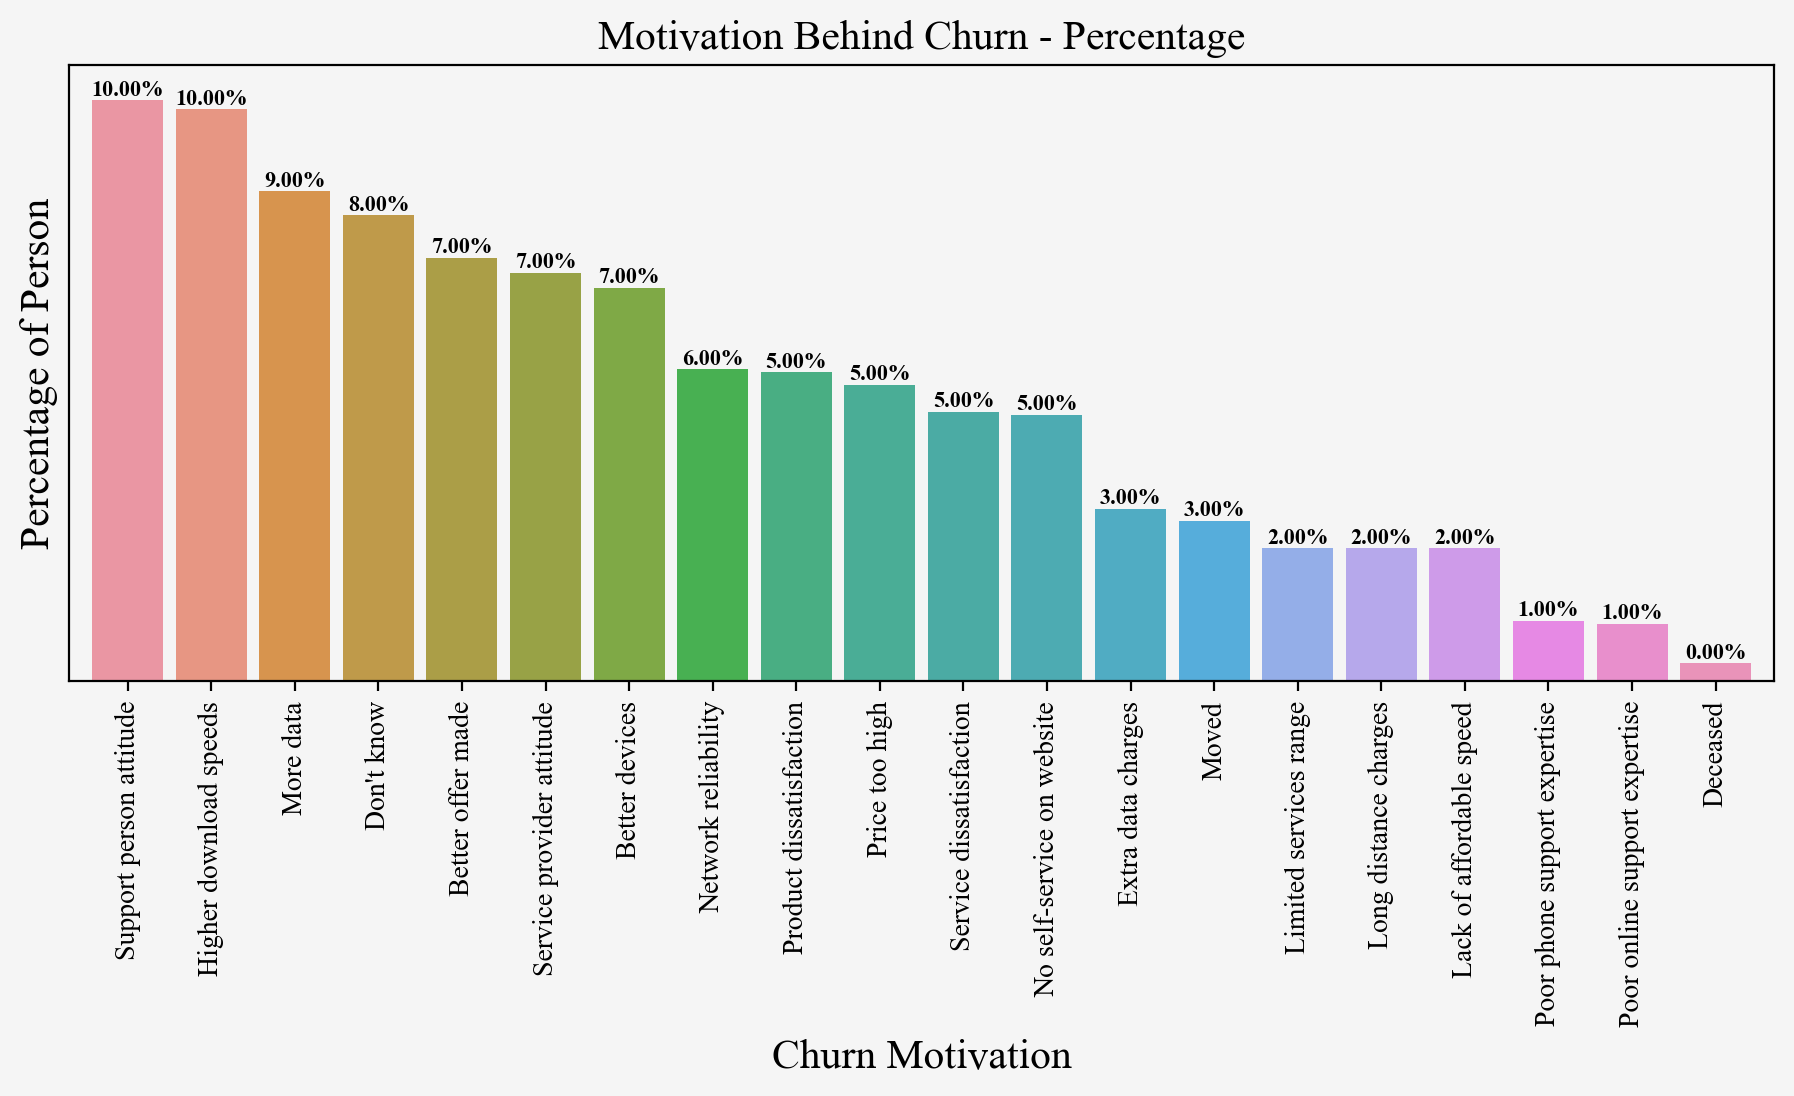

In [31]:
plt.figure(figsize=(11, 4), dpi=200)
ax = sns.barplot(data=churn_motivation, x='index', y='Churn Reason', width=.85)

for index in range(len(churn_motivation)):
    value = churn_motivation.loc[index, 'Percentage_Churn']
    ax.text(index, churn_motivation.loc[index, 'Churn Reason'], f"{value:.2%}", 
            ha='center', va='bottom', fontsize=8, color='black', fontweight='bold')

plt.title("Motivation Behind Churn - Percentage")
plt.xlabel('Churn Motivation')
plt.ylabel('Percentage of Person')
plt.yticks([])
plt.xticks(rotation=90)

x_min, x_max = ax.get_xlim()
offset = (x_max - x_min) * 0.01
ax.set_xlim(x_min - offset, x_max + offset)

y_min, y_max = ax.get_ylim()
offset = (y_max - y_min) * 0.01  
ax.set_ylim(y_min, y_max + offset)

plt.show()

In [14]:
restriction = [column for column in df.columns if len(df[column].unique()) == 2]

In [33]:

# Creo uno stile personalizzato per il titolo e l'evidenziazione
title_style = Style(color="bright_yellow", bold=True)
highlight_style = Style(color="bright_red")

# Creo un oggetto Console con lo stile personalizzato
console = Console()

def chern_reason_research(data, reason, restriction):
    for column in data.columns: 
        if column in restriction:
            console.print(f"[{title_style}]Nome della colonna:[/]", f"{column}")
            console.print(f"[{title_style}]Customers who have churn for:[/]", f"{reason}")
            console.print(f"[{highlight_style}]Numero di Persone:[/]\n", f"{data[data['Churn Reason'] == reason][column].value_counts()}")
            console.print(f"[{highlight_style}]Percentuale:[/]\n", f"{data[data['Churn Reason'] == reason][column].value_counts(normalize=True) * 100}")
            console.print()  # Stampo una linea vuota tra i risultati
            
# Controllo le prime 12 motivazioni
for reason in churn_motivation[:12]['index'].to_list():
    chern_reason_research(data=df, reason=reason, restriction=restriction)

Nome della colonna: Gender

Customers who have churn for: Support person attitude

Numero di Persone:
 Female    102
Male       90
Name: Gender, dtype: int64

Percentuale:
 Female    53.125
Male      46.875
Name: Gender, dtype: float64

Nome della colonna: Senior Citizen

Customers who have churn for: Support person attitude

Numero di Persone:
 No     150
Yes     42
Name: Senior Citizen, dtype: int64

Percentuale:
 No     78.125
Yes    21.875
Name: Senior Citizen, dtype: float64

Nome della colonna: Partner

Customers who have churn for: Support person attitude

Numero di Persone:
 No     132
Yes     60
Name: Partner, dtype: int64

Percentuale:
 No     68.75
Yes    31.25
Name: Partner, dtype: float64

Nome della colonna: Dependents

Customers who have churn for: Support person attitude

Numero di Persone:
 No     183
Yes      9
Name: Dependents, dtype: int64

Percentuale:
 No     95.3125
Yes     4.6875
Name: Dependents, dtype: float64

Nome della colonna: Phone Service

Customers who have churn for: Support person attitude

Numero di Persone:
 Yes    179
No      13
Name: Phone Service, dtype: int64

Percentuale:
 Yes    93.229167
No      6.770833
Name: Phone Service, dtype: float64

Nome della colonna: Paperless Billing

Customers who have churn for: Support person attitude

Numero di Persone:
 Yes    142
No      50
Name: Paperless Billing, dtype: int64

Percentuale:
 Yes    73.958333
No     26.041667
Name: Paperless Billing, dtype: float64

Nome della colonna: Churn Label

Customers who have churn for: Support person attitude

Numero di Persone:
 Yes    192
Name: Churn Label, dtype: int64

Percentuale:
 Yes    100.0
Name: Churn Label, dtype: float64

Nome della colonna: Churn Value

Customers who have churn for: Support person attitude

Numero di Persone:
 1    192
Name: Churn Value, dtype: int64

Percentuale:
 1    100.0
Name: Churn Value, dtype: float64

Nome della colonna: Gender

Customers who have churn for: Higher download speeds

Numero di Persone:
 Female    103
Male       86
Name: Gender, dtype: int64

Percentuale:
 Female    54.497354
Male      45.502646
Name: Gender, dtype: float64

Nome della colonna: Senior Citizen

Customers who have churn for: Higher download speeds

Numero di Persone:
 No     140
Yes     49
Name: Senior Citizen, dtype: int64

Percentuale:
 No     74.074074
Yes    25.925926
Name: Senior Citizen, dtype: float64

Nome della colonna: Partner

Customers who have churn for: Higher download speeds

Numero di Persone:
 No     127
Yes     62
Name: Partner, dtype: int64

Percentuale:
 No     67.195767
Yes    32.804233
Name: Partner, dtype: float64

Nome della colonna: Dependents

Customers who have churn for: Higher download speeds

Numero di Persone:
 No     183
Yes      6
Name: Dependents, dtype: int64

Percentuale:
 No     96.825397
Yes     3.174603
Name: Dependents, dtype: float64

Nome della colonna: Phone Service

Customers who have churn for: Higher download speeds

Numero di Persone:
 Yes    171
No      18
Name: Phone Service, dtype: int64

Percentuale:
 Yes    90.47619
No      9.52381
Name: Phone Service, dtype: float64

Nome della colonna: Paperless Billing

Customers who have churn for: Higher download speeds

Numero di Persone:
 Yes    144
No      45
Name: Paperless Billing, dtype: int64

Percentuale:
 Yes    76.190476
No     23.809524
Name: Paperless Billing, dtype: float64

Nome della colonna: Churn Label

Customers who have churn for: Higher download speeds

Numero di Persone:
 Yes    189
Name: Churn Label, dtype: int64

Percentuale:
 Yes    100.0
Name: Churn Label, dtype: float64

Nome della colonna: Churn Value

Customers who have churn for: Higher download speeds

Numero di Persone:
 1    189
Name: Churn Value, dtype: int64

Percentuale:
 1    100.0
Name: Churn Value, dtype: float64

Nome della colonna: Gender

Customers who have churn for: More data

Numero di Persone:
 Male      83
Female    79
Name: Gender, dtype: int64

Percentuale:
 Male      51.234568
Female    48.765432
Name: Gender, dtype: float64

Nome della colonna: Senior Citizen

Customers who have churn for: More data

Numero di Persone:
 No     125
Yes     37
Name: Senior Citizen, dtype: int64

Percentuale:
 No     77.160494
Yes    22.839506
Name: Senior Citizen, dtype: float64

Nome della colonna: Partner

Customers who have churn for: More data

Numero di Persone:
 No     100
Yes     62
Name: Partner, dtype: int64

Percentuale:
 No     61.728395
Yes    38.271605
Name: Partner, dtype: float64

Nome della colonna: Dependents

Customers who have churn for: More data

Numero di Persone:
 No     155
Yes      7
Name: Dependents, dtype: int64

Percentuale:
 No     95.679012
Yes     4.320988
Name: Dependents, dtype: float64

Nome della colonna: Phone Service

Customers who have churn for: More data

Numero di Persone:
 Yes    146
No      16
Name: Phone Service, dtype: int64

Percentuale:
 Yes    90.123457
No      9.876543
Name: Phone Service, dtype: float64

Nome della colonna: Paperless Billing

Customers who have churn for: More data

Numero di Persone:
 Yes    124
No      38
Name: Paperless Billing, dtype: int64

Percentuale:
 Yes    76.54321
No     23.45679
Name: Paperless Billing, dtype: float64

Nome della colonna: Churn Label

Customers who have churn for: More data

Numero di Persone:
 Yes    162
Name: Churn Label, dtype: int64

Percentuale:
 Yes    100.0
Name: Churn Label, dtype: float64

Nome della colonna: Churn Value

Customers who have churn for: More data

Numero di Persone:
 1    162
Name: Churn Value, dtype: int64

Percentuale:
 1    100.0
Name: Churn Value, dtype: float64

Nome della colonna: Gender

Customers who have churn for: Don't know

Numero di Persone:
 Male      82
Female    72
Name: Gender, dtype: int64

Percentuale:
 Male      53.246753
Female    46.753247
Name: Gender, dtype: float64

Nome della colonna: Senior Citizen

Customers who have churn for: Don't know

Numero di Persone:
 No     123
Yes     31
Name: Senior Citizen, dtype: int64

Percentuale:
 No     79.87013
Yes    20.12987
Name: Senior Citizen, dtype: float64

Nome della colonna: Partner

Customers who have churn for: Don't know

Numero di Persone:
 No     99
Yes    55
Name: Partner, dtype: int64

Percentuale:
 No     64.285714
Yes    35.714286
Name: Partner, dtype: float64

Nome della colonna: Dependents

Customers who have churn for: Don't know

Numero di Persone:
 No     148
Yes      6
Name: Dependents, dtype: int64

Percentuale:
 No     96.103896
Yes     3.896104
Name: Dependents, dtype: float64

Nome della colonna: Phone Service

Customers who have churn for: Don't know

Numero di Persone:
 Yes    139
No      15
Name: Phone Service, dtype: int64

Percentuale:
 Yes    90.25974
No      9.74026
Name: Phone Service, dtype: float64

Nome della colonna: Paperless Billing

Customers who have churn for: Don't know

Numero di Persone:
 Yes    114
No      40
Name: Paperless Billing, dtype: int64

Percentuale:
 Yes    74.025974
No     25.974026
Name: Paperless Billing, dtype: float64

Nome della colonna: Churn Label

Customers who have churn for: Don't know

Numero di Persone:
 Yes    154
Name: Churn Label, dtype: int64

Percentuale:
 Yes    100.0
Name: Churn Label, dtype: float64

Nome della colonna: Churn Value

Customers who have churn for: Don't know

Numero di Persone:
 1    154
Name: Churn Value, dtype: int64

Percentuale:
 1    100.0
Name: Churn Value, dtype: float64

Nome della colonna: Gender

Customers who have churn for: Better offer made

Numero di Persone:
 Female    79
Male      61
Name: Gender, dtype: int64

Percentuale:
 Female    56.428571
Male      43.571429
Name: Gender, dtype: float64

Nome della colonna: Senior Citizen

Customers who have churn for: Better offer made

Numero di Persone:
 No     92
Yes    48
Name: Senior Citizen, dtype: int64

Percentuale:
 No     65.714286
Yes    34.285714
Name: Senior Citizen, dtype: float64

Nome della colonna: Partner

Customers who have churn for: Better offer made

Numero di Persone:
 No     97
Yes    43
Name: Partner, dtype: int64

Percentuale:
 No     69.285714
Yes    30.714286
Name: Partner, dtype: float64

Nome della colonna: Dependents

Customers who have churn for: Better offer made

Numero di Persone:
 No     134
Yes      6
Name: Dependents, dtype: int64

Percentuale:
 No     95.714286
Yes     4.285714
Name: Dependents, dtype: float64

Nome della colonna: Phone Service

Customers who have churn for: Better offer made

Numero di Persone:
 Yes    135
No       5
Name: Phone Service, dtype: int64

Percentuale:
 Yes    96.428571
No      3.571429
Name: Phone Service, dtype: float64

Nome della colonna: Paperless Billing

Customers who have churn for: Better offer made

Numero di Persone:
 Yes    105
No      35
Name: Paperless Billing, dtype: int64

Percentuale:
 Yes    75.0
No     25.0
Name: Paperless Billing, dtype: float64

Nome della colonna: Churn Label

Customers who have churn for: Better offer made

Numero di Persone:
 Yes    140
Name: Churn Label, dtype: int64

Percentuale:
 Yes    100.0
Name: Churn Label, dtype: float64

Nome della colonna: Churn Value

Customers who have churn for: Better offer made

Numero di Persone:
 1    140
Name: Churn Value, dtype: int64

Percentuale:
 1    100.0
Name: Churn Value, dtype: float64

Nome della colonna: Gender

Customers who have churn for: Service provider attitude

Numero di Persone:
 Female    68
Male      67
Name: Gender, dtype: int64

Percentuale:
 Female    50.37037
Male      49.62963
Name: Gender, dtype: float64

Nome della colonna: Senior Citizen

Customers who have churn for: Service provider attitude

Numero di Persone:
 No     97
Yes    38
Name: Senior Citizen, dtype: int64

Percentuale:
 No     71.851852
Yes    28.148148
Name: Senior Citizen, dtype: float64

Nome della colonna: Partner

Customers who have churn for: Service provider attitude

Numero di Persone:
 No     81
Yes    54
Name: Partner, dtype: int64

Percentuale:
 No     60.0
Yes    40.0
Name: Partner, dtype: float64

Nome della colonna: Dependents

Customers who have churn for: Service provider attitude

Numero di Persone:
 No     125
Yes     10
Name: Dependents, dtype: int64

Percentuale:
 No     92.592593
Yes     7.407407
Name: Dependents, dtype: float64

Nome della colonna: Phone Service

Customers who have churn for: Service provider attitude

Numero di Persone:
 Yes    118
No      17
Name: Phone Service, dtype: int64

Percentuale:
 Yes    87.407407
No     12.592593
Name: Phone Service, dtype: float64

Nome della colonna: Paperless Billing

Customers who have churn for: Service provider attitude

Numero di Persone:
 Yes    103
No      32
Name: Paperless Billing, dtype: int64

Percentuale:
 Yes    76.296296
No     23.703704
Name: Paperless Billing, dtype: float64

Nome della colonna: Churn Label

Customers who have churn for: Service provider attitude

Numero di Persone:
 Yes    135
Name: Churn Label, dtype: int64

Percentuale:
 Yes    100.0
Name: Churn Label, dtype: float64

Nome della colonna: Churn Value

Customers who have churn for: Service provider attitude

Numero di Persone:
 1    135
Name: Churn Value, dtype: int64

Percentuale:
 1    100.0
Name: Churn Value, dtype: float64

Nome della colonna: Gender

Customers who have churn for: Better devices

Numero di Persone:
 Male      78
Female    52
Name: Gender, dtype: int64

Percentuale:
 Male      60.0
Female    40.0
Name: Gender, dtype: float64

Nome della colonna: Senior Citizen

Customers who have churn for: Better devices

Numero di Persone:
 No     99
Yes    31
Name: Senior Citizen, dtype: int64

Percentuale:
 No     76.153846
Yes    23.846154
Name: Senior Citizen, dtype: float64

Nome della colonna: Partner

Customers who have churn for: Better devices

Numero di Persone:
 No     80
Yes    50
Name: Partner, dtype: int64

Percentuale:
 No     61.538462
Yes    38.461538
Name: Partner, dtype: float64

Nome della colonna: Dependents

Customers who have churn for: Better devices

Numero di Persone:
 No     124
Yes      6
Name: Dependents, dtype: int64

Percentuale:
 No     95.384615
Yes     4.615385
Name: Dependents, dtype: float64

Nome della colonna: Phone Service

Customers who have churn for: Better devices

Numero di Persone:
 Yes    113
No      17
Name: Phone Service, dtype: int64

Percentuale:
 Yes    86.923077
No     13.076923
Name: Phone Service, dtype: float64

Nome della colonna: Paperless Billing

Customers who have churn for: Better devices

Numero di Persone:
 Yes    95
No     35
Name: Paperless Billing, dtype: int64

Percentuale:
 Yes    73.076923
No     26.923077
Name: Paperless Billing, dtype: float64

Nome della colonna: Churn Label

Customers who have churn for: Better devices

Numero di Persone:
 Yes    130
Name: Churn Label, dtype: int64

Percentuale:
 Yes    100.0
Name: Churn Label, dtype: float64

Nome della colonna: Churn Value

Customers who have churn for: Better devices

Numero di Persone:
 1    130
Name: Churn Value, dtype: int64

Percentuale:
 1    100.0
Name: Churn Value, dtype: float64

Nome della colonna: Gender

Customers who have churn for: Network reliability

Numero di Persone:
 Female    54
Male      49
Name: Gender, dtype: int64

Percentuale:
 Female    52.427184
Male      47.572816
Name: Gender, dtype: float64

Nome della colonna: Senior Citizen

Customers who have churn for: Network reliability

Numero di Persone:
 No     78
Yes    25
Name: Senior Citizen, dtype: int64

Percentuale:
 No     75.728155
Yes    24.271845
Name: Senior Citizen, dtype: float64

Nome della colonna: Partner

Customers who have churn for: Network reliability

Numero di Persone:
 No     66
Yes    37
Name: Partner, dtype: int64

Percentuale:
 No     64.07767
Yes    35.92233
Name: Partner, dtype: float64

Nome della colonna: Dependents

Customers who have churn for: Network reliability

Numero di Persone:
 No     97
Yes     6
Name: Dependents, dtype: int64

Percentuale:
 No     94.174757
Yes     5.825243
Name: Dependents, dtype: float64

Nome della colonna: Phone Service

Customers who have churn for: Network reliability

Numero di Persone:
 Yes    95
No      8
Name: Phone Service, dtype: int64

Percentuale:
 Yes    92.23301
No      7.76699
Name: Phone Service, dtype: float64

Nome della colonna: Paperless Billing

Customers who have churn for: Network reliability

Numero di Persone:
 Yes    75
No     28
Name: Paperless Billing, dtype: int64

Percentuale:
 Yes    72.815534
No     27.184466
Name: Paperless Billing, dtype: float64

Nome della colonna: Churn Label

Customers who have churn for: Network reliability

Numero di Persone:
 Yes    103
Name: Churn Label, dtype: int64

Percentuale:
 Yes    100.0
Name: Churn Label, dtype: float64

Nome della colonna: Churn Value

Customers who have churn for: Network reliability

Numero di Persone:
 1    103
Name: Churn Value, dtype: int64

Percentuale:
 1    100.0
Name: Churn Value, dtype: float64

Nome della colonna: Gender

Customers who have churn for: Product dissatisfaction

Numero di Persone:
 Male      52
Female    50
Name: Gender, dtype: int64

Percentuale:
 Male      50.980392
Female    49.019608
Name: Gender, dtype: float64

Nome della colonna: Senior Citizen

Customers who have churn for: Product dissatisfaction

Numero di Persone:
 No     74
Yes    28
Name: Senior Citizen, dtype: int64

Percentuale:
 No     72.54902
Yes    27.45098
Name: Senior Citizen, dtype: float64

Nome della colonna: Partner

Customers who have churn for: Product dissatisfaction

Numero di Persone:
 No     56
Yes    46
Name: Partner, dtype: int64

Percentuale:
 No     54.901961
Yes    45.098039
Name: Partner, dtype: float64

Nome della colonna: Dependents

Customers who have churn for: Product dissatisfaction

Numero di Persone:
 No     94
Yes     8
Name: Dependents, dtype: int64

Percentuale:
 No     92.156863
Yes     7.843137
Name: Dependents, dtype: float64

Nome della colonna: Phone Service

Customers who have churn for: Product dissatisfaction

Numero di Persone:
 Yes    91
No     11
Name: Phone Service, dtype: int64

Percentuale:
 Yes    89.215686
No     10.784314
Name: Phone Service, dtype: float64

Nome della colonna: Paperless Billing

Customers who have churn for: Product dissatisfaction

Numero di Persone:
 Yes    74
No     28
Name: Paperless Billing, dtype: int64

Percentuale:
 Yes    72.54902
No     27.45098
Name: Paperless Billing, dtype: float64

Nome della colonna: Churn Label

Customers who have churn for: Product dissatisfaction

Numero di Persone:
 Yes    102
Name: Churn Label, dtype: int64

Percentuale:
 Yes    100.0
Name: Churn Label, dtype: float64

Nome della colonna: Churn Value

Customers who have churn for: Product dissatisfaction

Numero di Persone:
 1    102
Name: Churn Value, dtype: int64

Percentuale:
 1    100.0
Name: Churn Value, dtype: float64

Nome della colonna: Gender

Customers who have churn for: Price too high

Numero di Persone:
 Female    56
Male      42
Name: Gender, dtype: int64

Percentuale:
 Female    57.142857
Male      42.857143
Name: Gender, dtype: float64

Nome della colonna: Senior Citizen

Customers who have churn for: Price too high

Numero di Persone:
 No     64
Yes    34
Name: Senior Citizen, dtype: int64

Percentuale:
 No     65.306122
Yes    34.693878
Name: Senior Citizen, dtype: float64

Nome della colonna: Partner

Customers who have churn for: Price too high

Numero di Persone:
 No     70
Yes    28
Name: Partner, dtype: int64

Percentuale:
 No     71.428571
Yes    28.571429
Name: Partner, dtype: float64

Nome della colonna: Dependents

Customers who have churn for: Price too high

Numero di Persone:
 No     92
Yes     6
Name: Dependents, dtype: int64

Percentuale:
 No     93.877551
Yes     6.122449
Name: Dependents, dtype: float64

Nome della colonna: Phone Service

Customers who have churn for: Price too high

Numero di Persone:
 Yes    91
No      7
Name: Phone Service, dtype: int64

Percentuale:
 Yes    92.857143
No      7.142857
Name: Phone Service, dtype: float64

Nome della colonna: Paperless Billing

Customers who have churn for: Price too high

Numero di Persone:
 Yes    73
No     25
Name: Paperless Billing, dtype: int64

Percentuale:
 Yes    74.489796
No     25.510204
Name: Paperless Billing, dtype: float64

Nome della colonna: Churn Label

Customers who have churn for: Price too high

Numero di Persone:
 Yes    98
Name: Churn Label, dtype: int64

Percentuale:
 Yes    100.0
Name: Churn Label, dtype: float64

Nome della colonna: Churn Value

Customers who have churn for: Price too high

Numero di Persone:
 1    98
Name: Churn Value, dtype: int64

Percentuale:
 1    100.0
Name: Churn Value, dtype: float64

Nome della colonna: Gender

Customers who have churn for: Service dissatisfaction

Numero di Persone:
 Male      50
Female    39
Name: Gender, dtype: int64

Percentuale:
 Male      56.179775
Female    43.820225
Name: Gender, dtype: float64

Nome della colonna: Senior Citizen

Customers who have churn for: Service dissatisfaction

Numero di Persone:
 No     69
Yes    20
Name: Senior Citizen, dtype: int64

Percentuale:
 No     77.52809
Yes    22.47191
Name: Senior Citizen, dtype: float64

Nome della colonna: Partner

Customers who have churn for: Service dissatisfaction

Numero di Persone:
 No     54
Yes    35
Name: Partner, dtype: int64

Percentuale:
 No     60.674157
Yes    39.325843
Name: Partner, dtype: float64

Nome della colonna: Dependents

Customers who have churn for: Service dissatisfaction

Numero di Persone:
 No     80
Yes     9
Name: Dependents, dtype: int64

Percentuale:
 No     89.88764
Yes    10.11236
Name: Dependents, dtype: float64

Nome della colonna: Phone Service

Customers who have churn for: Service dissatisfaction

Numero di Persone:
 Yes    81
No      8
Name: Phone Service, dtype: int64

Percentuale:
 Yes    91.011236
No      8.988764
Name: Phone Service, dtype: float64

Nome della colonna: Paperless Billing

Customers who have churn for: Service dissatisfaction

Numero di Persone:
 Yes    71
No     18
Name: Paperless Billing, dtype: int64

Percentuale:
 Yes    79.775281
No     20.224719
Name: Paperless Billing, dtype: float64

Nome della colonna: Churn Label

Customers who have churn for: Service dissatisfaction

Numero di Persone:
 Yes    89
Name: Churn Label, dtype: int64

Percentuale:
 Yes    100.0
Name: Churn Label, dtype: float64

Nome della colonna: Churn Value

Customers who have churn for: Service dissatisfaction

Numero di Persone:
 1    89
Name: Churn Value, dtype: int64

Percentuale:
 1    100.0
Name: Churn Value, dtype: float64

Nome della colonna: Gender

Customers who have churn for: No self-service on website

Numero di Persone:
 Male      47
Female    41
Name: Gender, dtype: int64

Percentuale:
 Male      53.409091
Female    46.590909
Name: Gender, dtype: float64

Nome della colonna: Senior Citizen

Customers who have churn for: No self-service on website

Numero di Persone:
 No     71
Yes    17
Name: Senior Citizen, dtype: int64

Percentuale:
 No     80.681818
Yes    19.318182
Name: Senior Citizen, dtype: float64

Nome della colonna: Partner

Customers who have churn for: No self-service on website

Numero di Persone:
 No     55
Yes    33
Name: Partner, dtype: int64

Percentuale:
 No     62.5
Yes    37.5
Name: Partner, dtype: float64

Nome della colonna: Dependents

Customers who have churn for: No self-service on website

Numero di Persone:
 No     80
Yes     8
Name: Dependents, dtype: int64

Percentuale:
 No     90.909091
Yes     9.090909
Name: Dependents, dtype: float64

Nome della colonna: Phone Service

Customers who have churn for: No self-service on website

Numero di Persone:
 Yes    79
No      9
Name: Phone Service, dtype: int64

Percentuale:
 Yes    89.772727
No     10.227273
Name: Phone Service, dtype: float64

Nome della colonna: Paperless Billing

Customers who have churn for: No self-service on website

Numero di Persone:
 Yes    70
No     18
Name: Paperless Billing, dtype: int64

Percentuale:
 Yes    79.545455
No     20.454545
Name: Paperless Billing, dtype: float64

Nome della colonna: Churn Label

Customers who have churn for: No self-service on website

Numero di Persone:
 Yes    88
Name: Churn Label, dtype: int64

Percentuale:
 Yes    100.0
Name: Churn Label, dtype: float64

Nome della colonna: Churn Value

Customers who have churn for: No self-service on website

Numero di Persone:
 1    88
Name: Churn Value, dtype: int64

Percentuale:
 1    100.0
Name: Churn Value, dtype: float64

In [34]:
print("Internet Service:")
print("Customers who have churned for a better download speeds")
print(f"""
---------------------------------------
Numero di Persone:\n{df[df['Churn Reason']=='Higher download speeds']['Internet Service'].value_counts()}
---------------------------------------
Percentuale:\n{df[df['Churn Reason']=='Higher download speeds']['Internet Service'].value_counts('percentage')*100}
---------------------------------------
""")

Internet Service:

Customers who have churned for a better download speeds

---------------------------------------
Numero di Persone:
Fiber optic    130
DSL             51
No               8
Name: Internet Service, dtype: int64
---------------------------------------
Percentuale:
Fiber optic    68.783069
DSL            26.984127
No              4.232804
Name: Internet Service, dtype: float64
---------------------------------------

### churned caused by Support person attitude

In [35]:
print("Phone Service:")
print("Customers who have churned caused by Support person attitude")
print(f"""
---------------------------------------
Numero di Persone:\n{df[df['Churn Reason']=='Support person attitude']['Phone Service'].value_counts()}
---------------------------------------
Percentuale:\n{df[df['Churn Reason']=='Support person attitude']['Phone Service'].value_counts('percentage')*100}
---------------------------------------
""")

Phone Service:

Customers who have churned caused by Support person attitude

---------------------------------------
Numero di Persone:
Yes    179
No      13
Name: Phone Service, dtype: int64
---------------------------------------
Percentuale:
Yes    93.229167
No      6.770833
Name: Phone Service, dtype: float64
---------------------------------------

**!!!** Questo è un dato che potrebbe rivelarsi molto importante.
la causa è questa: `Support person attitude`  e io sto controllando tra coloro che hanno fatto churn 
chi avesse o meno un `Phone Service` (ovvero che l'azienda ti fornisce un provider e supporto telefonico).

### Customers who have churn caused by absence of Datas

In [36]:
print("Streaming TV:")
print("Customers who have churned caused by absence of Datas")
print(f"""
---------------------------------------
Numero di Persone:\n{df[df['Churn Reason']=='More data']['Streaming TV'].value_counts()}
---------------------------------------
Percentuale:\n{df[df['Churn Reason']=='More data']['Streaming TV'].value_counts('percentage')*100}
---------------------------------------
""")

Streaming TV:

Customers who have churned caused by absence of Datas

---------------------------------------
Numero di Persone:
No                     77
Yes                    74
No internet service    11
Name: Streaming TV, dtype: int64
---------------------------------------
Percentuale:
No                     47.530864
Yes                    45.679012
No internet service     6.790123
Name: Streaming TV, dtype: float64
---------------------------------------

In [37]:
print("Streaming Movies:")
print("Customers who have churned caused by absence of Datas")
print(f"""
---------------------------------------
Numero di Persone:\n{df[df['Churn Reason']=='More data']['Streaming Movies'].value_counts()}
---------------------------------------
Percentuale:\n{df[df['Churn Reason']=='More data']['Streaming Movies'].value_counts('percentage')*100}
---------------------------------------
""")

Streaming Movies:

Customers who have churned caused by absence of Datas

---------------------------------------
Numero di Persone:
No                     78
Yes                    73
No internet service    11
Name: Streaming Movies, dtype: int64
---------------------------------------
Percentuale:
No                     48.148148
Yes                    45.061728
No internet service     6.790123
Name: Streaming Movies, dtype: float64
---------------------------------------

# Data Preprocessing - Columns

In [15]:
geodata = df[['City', 'Zip Code', 'Latitude', 'Longitude', 'Lat Long']]
geodata.head()

,City,Zip Code,Latitude,Longitude,Lat Long
0,Los Angeles,90003,33.964131,-118.272783,"33.964131, -118.272783"
1,Los Angeles,90005,34.059281,-118.307420,"34.059281, -118.30742"
2,Los Angeles,90006,34.048013,-118.293953,"34.048013, -118.293953"
3,Los Angeles,90010,34.062125,-118.315709,"34.062125, -118.315709"
4,Los Angeles,90015,34.039224,-118.266293,"34.039224, -118.266293"


In [16]:
col_to_be_removed = ['Count','Country','State','Zip Code', 'CustomerID', 
                     'City', 'Zip Code', 'Latitude', 'Longitude', 'Lat Long']

df = df.drop(col_to_be_removed, axis=1)

# Data Encoding

In [19]:
# Mi salvo la variabile dipendente `Churn Value`
y = df['Churn Value']

In [20]:
df.drop(['Churn Score', 'Churn Label', 'Churn Reason','tenure_range','Churn Value'], axis=1, inplace=True)

In [21]:
# variabili binarie -> label encoder (dummies)
binary_col = []
# variabili Numeriche
num_col = []
# Variabili non binarie -> one hot encoder
obj_col = []

for col in df.columns:
    if len(df[col].unique()) == 2:
        binary_col.append(col)
    elif len(df[col].unique()) > 2 and df[col].dtype in [np.int64, np.float32, np.float64]:
        num_col.append(col)
    else:
        obj_col.append(col)

In [43]:
print("Binary:")
print(binary_col)
print("\nNumeric:")
print(num_col)
print("\nObject:")
print(obj_col)

Binary:

['Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Phone Service', 'Paperless Billing']

Numeric:

['Tenure Months', 'Monthly Charges', 'Total Charges', 'CLTV']

Object:

[
    'Multiple Lines',
    'Internet Service',
    'Online Security',
    'Online Backup',
    'Device Protection',
    'Tech Support',
    'Streaming TV',
    'Streaming Movies',
    'Contract',
    'Payment Method'
]

In [22]:
df_encoded = pd.get_dummies(data=df, columns=binary_col, drop_first=True)

In [23]:
encoder = OneHotEncoder(sparse_output=False)
encoder.fit(df_encoded[obj_col])
cols = encoder.get_feature_names_out()
encoded_obj = encoder.fit_transform(df[obj_col])

In [24]:
encoded_obj_df = pd.DataFrame(encoded_obj, columns=cols)
df_encoded = pd.concat([df_encoded, encoded_obj_df], axis=1)

In [25]:
df_encoded.drop(['Tenure Months','Multiple Lines','Internet Service',
                'Online Security', 'Online Backup', 'Device Protection', 'Tech Support',
                'Streaming TV', 'Streaming Movies', 'Contract','Multiple Lines'] ,axis=1, inplace=True)
df_encoded.drop('Payment Method', axis=1, inplace=True)

In [26]:
df_encoded.head(3)

,Monthly Charges,Total Charges,CLTV,Gender_Male,Senior Citizen_Yes,Partner_Yes,Dependents_Yes,Phone Service_Yes,Paperless Billing_Yes,Multiple Lines_No,Multiple Lines_No phone service,Multiple Lines_Yes,Internet Service_DSL,Internet Service_Fiber optic,Internet Service_No,Online Security_No,Online Security_No internet service,Online Security_Yes,Online Backup_No,Online Backup_No internet service,Online Backup_Yes,Device Protection_No,Device Protection_No internet service,Device Protection_Yes,Tech Support_No,Tech Support_No internet service,Tech Support_Yes,Streaming TV_No,Streaming TV_No internet service,Streaming TV_Yes,Streaming Movies_No,Streaming Movies_No internet service,Streaming Movies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,Payment Method_Bank transfer (automatic),Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check
0,53.85,108.150002,3239,1,0,0,0,1,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,70.70,151.649994,2701,0,0,0,1,1,1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,99.65,820.500000,5372,0,0,0,1,1,1,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [27]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_encoded)
column = scaler.get_feature_names_out()

In [28]:
df_scaled = pd.DataFrame(df_scaled, columns=column)

In [51]:
df_scaled.head(3)

,Monthly Charges,Total Charges,CLTV,Gender_Male,Senior Citizen_Yes,Partner_Yes,Dependents_Yes,Phone Service_Yes,Paperless Billing_Yes,Multiple Lines_No,Multiple Lines_No phone service,Multiple Lines_Yes,Internet Service_DSL,Internet Service_Fiber optic,Internet Service_No,Online Security_No,Online Security_No internet service,Online Security_Yes,Online Backup_No,Online Backup_No internet service,Online Backup_Yes,Device Protection_No,Device Protection_No internet service,Device Protection_Yes,Tech Support_No,Tech Support_No internet service,Tech Support_Yes,Streaming TV_No,Streaming TV_No internet service,Streaming TV_Yes,Streaming Movies_No,Streaming Movies_No internet service,Streaming Movies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,Payment Method_Bank transfer (automatic),Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check
0,0.354229,0.012453,0.274850,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.521891,0.017462,0.155215,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.809950,0.094475,0.749166,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [52]:
df_correlation = pd.concat([df_scaled, y], axis=1)

In [53]:
correlation = df_correlation.corr()['Churn Value'][:-1].reset_index().sort_values('Churn Value', ascending=False)

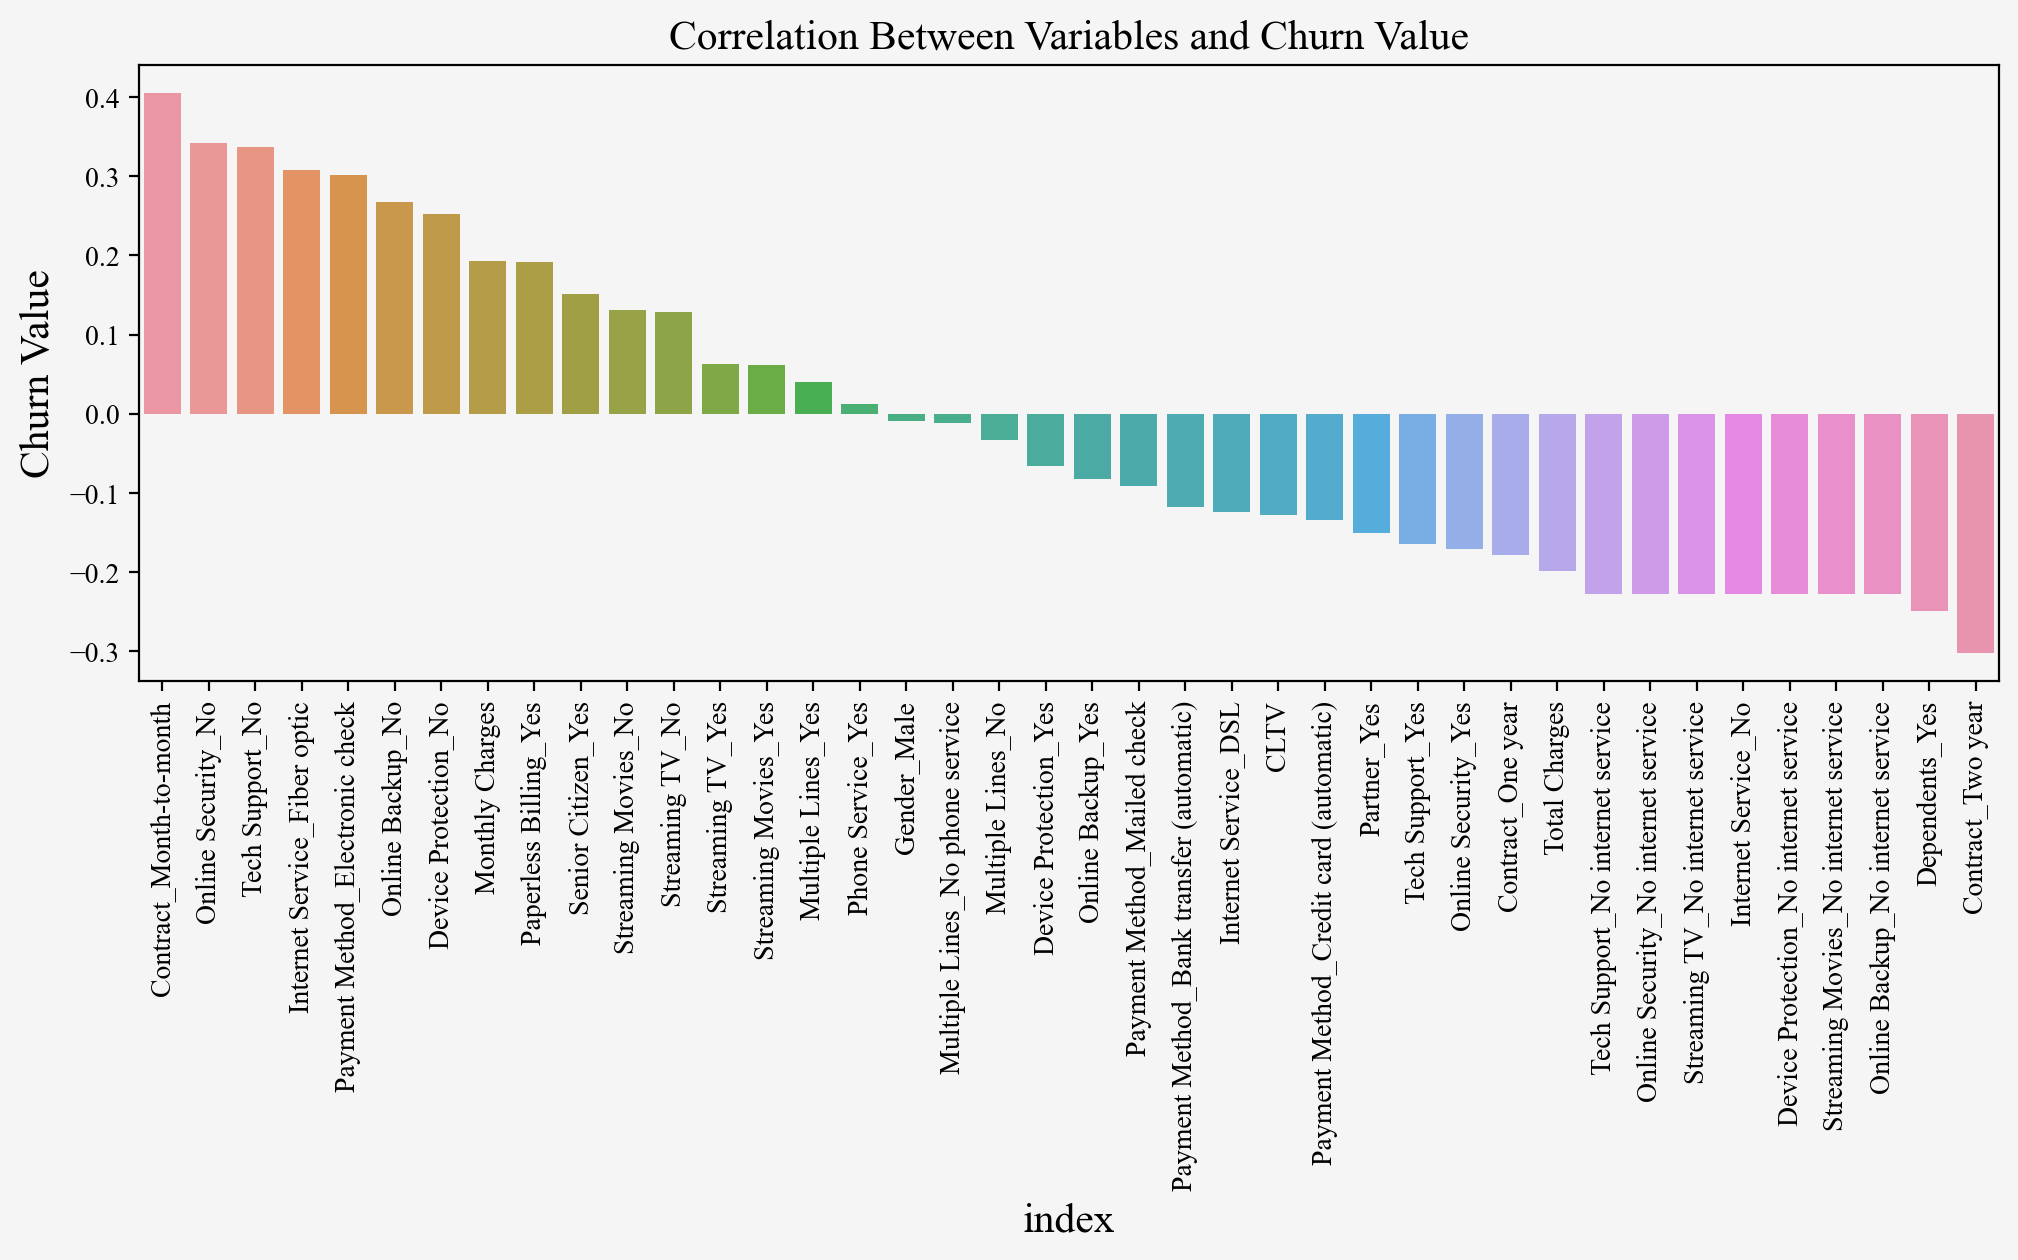

In [54]:
plt.figure(figsize=(12,4), dpi=200)
sns.barplot(data=correlation, x='index', y='Churn Value')
plt.xticks(rotation=90)
plt.title("Correlation Between Variables and Churn Value")
plt.show()

In [55]:
correlation_copy = correlation.copy()
negative_corr = correlation_copy.nsmallest(10, 'Churn Value')
positive_corr = correlation_copy.nlargest(10, 'Churn Value')
top20_correlation = pd.concat([negative_corr, positive_corr], axis=0)
top20_correlation = top20_correlation.sort_values('Churn Value', ascending=False).reset_index(drop=True)

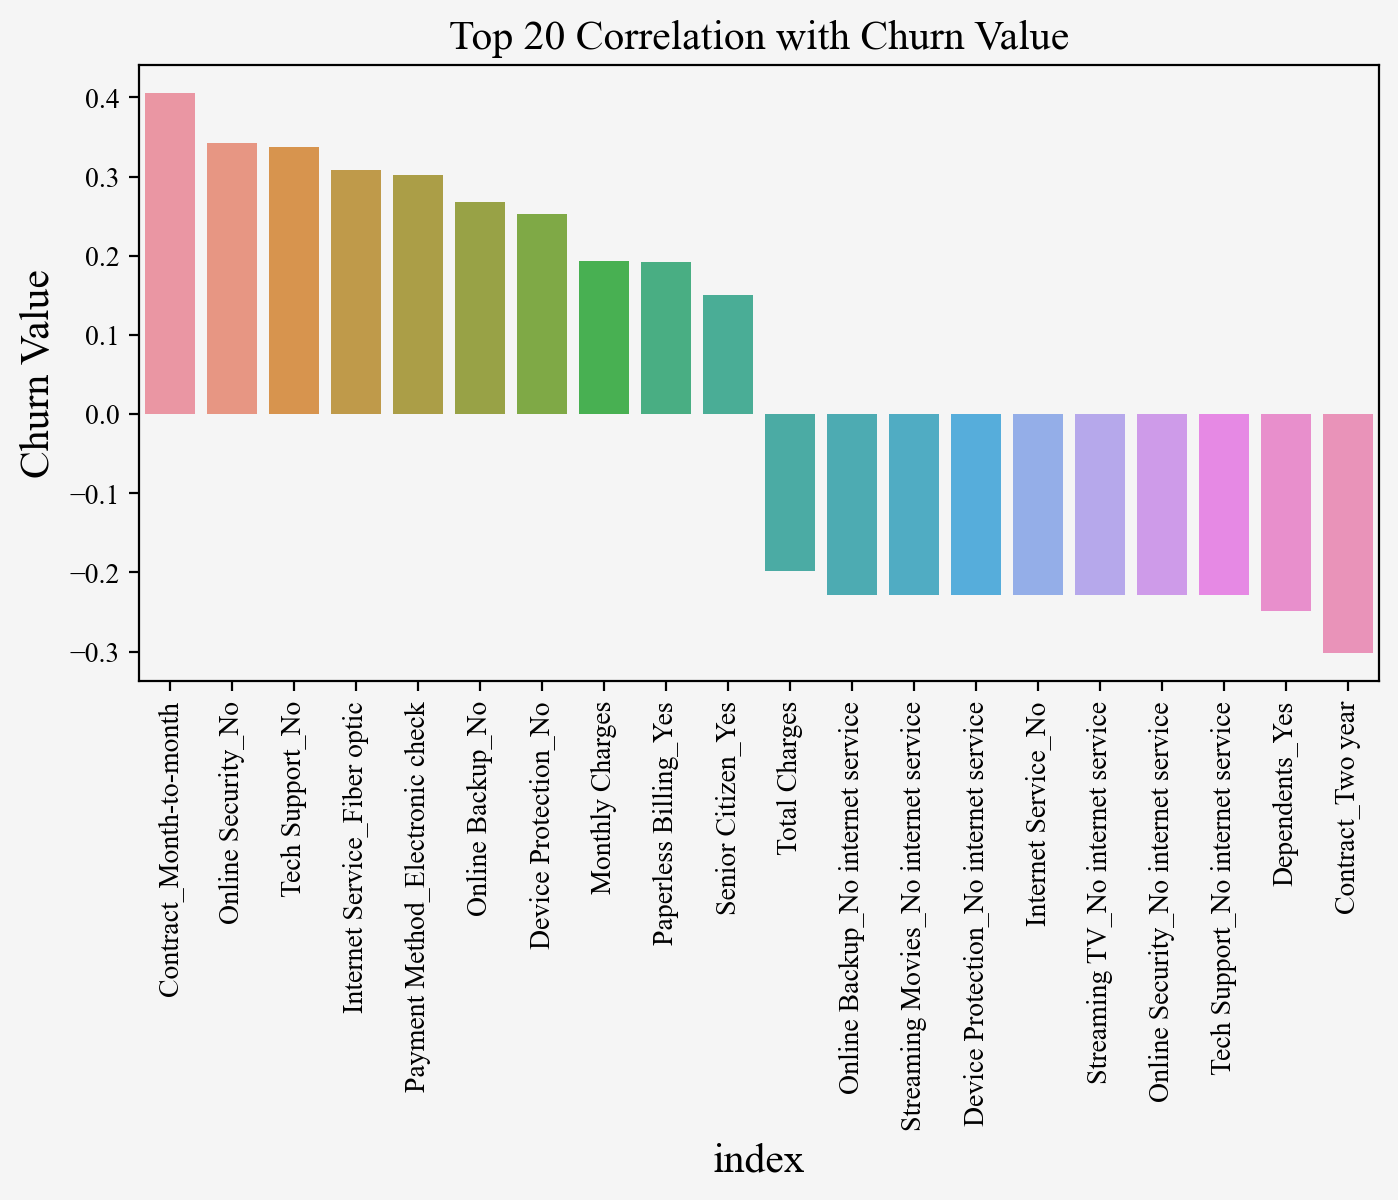

In [56]:
plt.figure(figsize=(8,4), dpi=200)
sns.barplot(data=top20_correlation, x='index', y='Churn Value')
plt.xticks(rotation=90)
plt.title('Top 20 Correlation with Churn Value');

# Machine Learning

In [29]:
X = df_scaled
y = y

In [30]:
rnd = 42
splitter = StratifiedShuffleSplit(random_state=rnd, test_size=0.4, n_splits=1)

for train_index, test_index in splitter.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [31]:
splitter2 = StratifiedShuffleSplit(random_state=rnd, test_size=0.5, n_splits=1)

for train_index, test_index in splitter.split(X_test, y_test):
    X_test, X_val = X.iloc[train_index], X.iloc[test_index]
    y_test, y_val = y.iloc[train_index], y.iloc[test_index]

In [32]:
print(f"""
X_train: {X_train.shape}

y_train: {y_train.shape}

X_test: {X_test.shape}

y_test: {y_test.shape}

X_val:  {X_val.shape}

y_val:  {y_val.shape}
""")

X_train: (4225, 40)

y_train: (4225,)

X_test: (1690, 40)

y_test: (1690,)

X_val:  (1128, 40)

y_val:  (1128,)

### KBest

Non utilizzerò solo le K-migliori colonne, questo passaggio è solo a scopo illustrativo 
e per far capire quali sono le colonne che si portano dietro l'informazione maggiore.

In [33]:
def select_best_features(n_best_features, X_train, y_train, X_test):
    feature_selector = SelectKBest(score_func=f_classif, k=n_best_features)
    feature_selector.fit(X_train, y_train)
    
    feature_scores = pd.DataFrame({
        'Feature': X_train.columns,
        'Score': feature_selector.scores_
    })
    sorted_features = feature_scores.sort_values(by='Score', ascending=False)
    selected_features = sorted_features.head(n_best_features)['Feature'].tolist()
    
    X_train_selected = feature_selector.transform(X_train)
    X_test_selected = feature_selector.transform(X_test)
    
    return selected_features, X_train_selected, X_test_selected

In [34]:
n_best_features, X_train_fs, X_test_fs = select_best_features(20, X_train, y_train, X_test)

In [35]:
n_best_features

['Contract_Month-to-month',
 'Tech Support_No',
 'Online Security_No',
 'Internet Service_Fiber optic',
 'Payment Method_Electronic check',
 'Contract_Two year',
 'Online Backup_No',
 'Dependents_Yes',
 'Device Protection_No',
 'Online Security_No internet service',
 'Streaming TV_No internet service',
 'Tech Support_No internet service',
 'Device Protection_No internet service',
 'Online Backup_No internet service',
 'Streaming Movies_No internet service',
 'Internet Service_No',
 'Paperless Billing_Yes',
 'Monthly Charges',
 'Total Charges',
 'Contract_One year']

In [61]:
def classification_models():
    models = []
    models.append(('LogisticRegression', LogisticRegression()))
    models.append(('RandomForest', RandomForestClassifier(n_estimators=60, random_state=10)))
    models.append(('GradientBoostingClassifier', GradientBoostingClassifier(random_state=10)))
    models.append(('XGBClassifier', xgb.XGBClassifier(random_state=10, booster="gbtree")))
    models.append(('AdaBoost', AdaBoostClassifier(random_state=10))
    models.append(('svc', SVC(random_state=10, kernel='rbf')))
    
    return models

models = classification_models()

In [62]:
model_style = Style(color="bright_red", bold=True)

def model_fit_evaluate(models, X_train, y_train, X_eval, y_eval):
    # fit
    for model in models:
        console.print(f"[{highlight_style}] {model[0]} \n")
        model[1].fit(X_train, y_train)
        y_pred = model[1].predict(X_eval)
        
        # Evaluation
        accuracy = accuracy_score(y_eval, y_pred)
        recall = recall_score(y_eval, y_pred)
        cm = confusion_matrix(y_eval, y_pred)
        cr = classification_report(y_eval, y_pred)
    
        # Print
        print(f"""
        accuracy: {accuracy}
        recall: {recall}\n
        Confusion Matrix:\n{cm}\n
        classification report:\n{cr}\n
        """)

In [63]:
model_fit_evaluate(models, X_train, y_train, X_val, np.ravel(y_val))

 LogisticRegression 

accuracy: 0.6693262411347518
        recall: 0.5554054054054054

        Confusion Matrix:
[[344  44]
 [329 411]]

        classification report:
              precision    recall  f1-score   support

           0       0.51      0.89      0.65       388
           1       0.90      0.56      0.69       740

    accuracy                           0.67      1128
   macro avg       0.71      0.72      0.67      1128
weighted avg       0.77      0.67      0.67      1128

 RandomForest 

accuracy: 0.8581560283687943
        recall: 0.8013513513513514

        Confusion Matrix:
[[375  13]
 [147 593]]

        classification report:
              precision    recall  f1-score   support

           0       0.72      0.97      0.82       388
           1       0.98      0.80      0.88       740

    accuracy                           0.86      1128
   macro avg       0.85      0.88      0.85      1128
weighted avg       0.89      0.86      0.86      1128

 GradientBoostingClassifier 

accuracy: 0.7012411347517731
        recall: 0.595945945945946

        Confusion Matrix:
[[350  38]
 [299 441]]

        classification report:
              precision    recall  f1-score   support

           0       0.54      0.90      0.68       388
           1       0.92      0.60      0.72       740

    accuracy                           0.70      1128
   macro avg       0.73      0.75      0.70      1128
weighted avg       0.79      0.70      0.71      1128

 XGBClassifier 

accuracy: 0.8333333333333334
        recall: 0.7810810810810811

        Confusion Matrix:
[[362  26]
 [162 578]]

        classification report:
              precision    recall  f1-score   support

           0       0.69      0.93      0.79       388
           1       0.96      0.78      0.86       740

    accuracy                           0.83      1128
   macro avg       0.82      0.86      0.83      1128
weighted avg       0.87      0.83      0.84      1128

 svc 

accuracy: 0.6764184397163121
        recall: 0.5486486486486486

        Confusion Matrix:
[[357  31]
 [334 406]]

        classification report:
              precision    recall  f1-score   support

           0       0.52      0.92      0.66       388
           1       0.93      0.55      0.69       740

    accuracy                           0.68      1128
   macro avg       0.72      0.73      0.68      1128
weighted avg       0.79      0.68      0.68      1128

## RandomForestClassifier

In [64]:
rf = RandomForestClassifier()

In [65]:
param_grid = {
    "n_estimators": [10, 60, 100, 150, 200, 250],
    "criterion": ['gini', 'entropy'],
    "min_samples_split": [2,3,4],
    "max_features": ["sqrt", "log2"],
    "min_samples_leaf":[1,2,3]
}

In [66]:
grid = GridSearchCV(estimator=rf, param_grid=param_grid, n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [10, 60, 100, 150, 200, 250]})

In [67]:
grid.best_estimator_

RandomForestClassifier(criterion='entropy', min_samples_leaf=2,
                       min_samples_split=3, n_estimators=60)

**Best Param**: 
1) RandomForestClassifier(min_samples_leaf=3, min_samples_split=4,
                       n_estimators=150)
                       
2) RandomForestClassifier(criterion='entropy', min_samples_leaf=2,
                       min_samples_split=3, n_estimators=60)

In [68]:
y_pred = grid.predict(X_test)

In [69]:
cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))

precision    recall  f1-score   support

           0       0.61      0.96      0.75       561
           1       0.97      0.70      0.81      1129

    accuracy                           0.78      1690
   macro avg       0.79      0.83      0.78      1690
weighted avg       0.85      0.78      0.79      1690

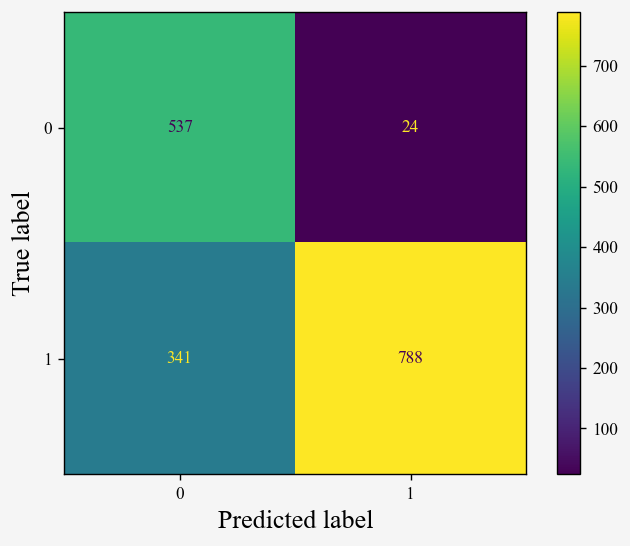

In [70]:
ConfusionMatrixDisplay(cm).plot()

## XGBClassifier

In [71]:
xgbc = XGBClassifier()

In [72]:
param_grid = {
    "n_estimators": [2, 5, 10, 15, 20, 30, 40, 2 * len(X)],
    "objective": ["binary:logistic"],
    "tree_method": ["auto", "exact", "approx", "hist", "gpu_hist"],
    "max_depth": [3, 5, 7, 9],
    "min_child_weight": [1, 3, 5],
    "gamma": [0, 0.1, 0.2, 0.3],
    "subsample": [0.8, 0.9, 1.0]
}

In [73]:
grid = RandomizedSearchCV(xgbc, param_grid, n_jobs=-1)
grid.fit(X_train, y_train)

RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None...
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None, ...),
                   n_jobs=-1,
                   param_distributions={'gamma': [0, 0.1, 0.2, 0.3],
                                        'max_depth': [3, 5, 7, 9],
                                        'min_child_weight': [1, 3, 5],
                                        'n_estimators': [2, 5, 10, 15, 20, 30,
                                                         40, 14086],
                                        'objective': ['binary:logistic'],
                                        'subsample': [0.8, 0.9, 1.0],
                                        'tree_method': ['auto', 'exact',
                                                        'approx', 'hist',
                                                        'gpu_hist']})

In [74]:
grid.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              n_estimators=30, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [75]:
y_pred = grid.predict(X_test)

In [76]:
cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))

precision    recall  f1-score   support

           0       0.52      0.92      0.66       561
           1       0.94      0.58      0.71      1129

    accuracy                           0.69      1690
   macro avg       0.73      0.75      0.69      1690
weighted avg       0.80      0.69      0.70      1690

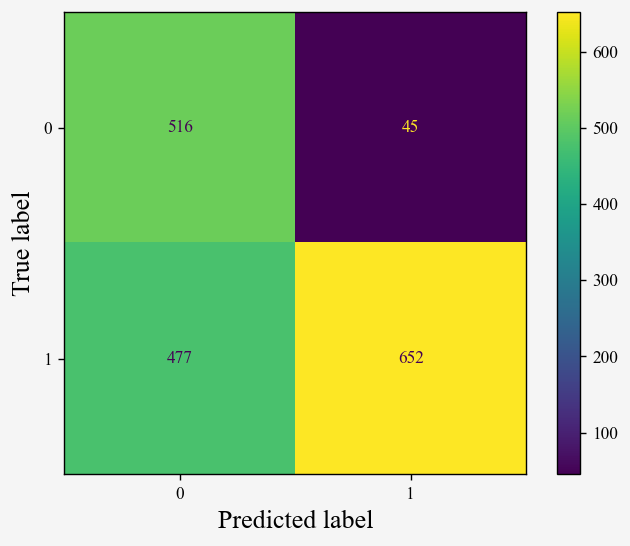

In [77]:
ConfusionMatrixDisplay(cm).plot()

## ANN

In [104]:
y_val = y_val.astype('float32')
y_train = y_train.astype('float32')

array([0, 1], dtype=int64)

In [78]:
ann = tf.keras.models.Sequential()

In [79]:
ann.add(tf.keras.layers.Dense(units=40, activation='relu'))

In [80]:
ann.add(tf.keras.layers.Dense(units=40, activation='relu'))

In [81]:
ann.add(tf.keras.layers.Dense(units=40, activation='relu'))

In [82]:
ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

In [105]:
ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.F1Score()])

In [106]:
ann.fit(X_train, y_train, batch_size = 32, epochs = 200)

Epoch 1/200
133/133 [==============================] - 1s 1ms/step - loss: 0.0899 - binary_accuracy: 0.9591 - precision_2: 0.9225 - recall_2: 0.9233 - f1_score: 0.5625
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.0840 - binary_accuracy: 0.9607 - precision_2: 0.9290 - recall_2: 0.9224 - f1_score: 0.5669
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.0864 - binary_accuracy: 0.9624 - precision_2: 0.9302 - recall_2: 0.9277 - f1_score: 0.5673
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.0894 - binary_accuracy: 0.9617 - precision_2: 0.9324 - recall_2: 0.9224 - f1_score: 0.5646
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.0817 - binary_accuracy: 0.9638 - precision_2: 0.9384 - recall_2: 0.9242 - f1_score: 0.5639
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.0809 - binary_accuracy: 0.9640 - precision_2: 0.9330 - recall_2: 0.9313 - f1_score:

In [107]:
ann.get_build_config()

{'input_shape': (None, 40)}

In [108]:
ann.get_metrics_result()

{'loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.076937556>,
 'binary_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.96639055>,
 'precision_2': <tf.Tensor: shape=(), dtype=float32, numpy=0.9454049>,
 'recall_2': <tf.Tensor: shape=(), dtype=float32, numpy=0.92685103>,
 'f1_score': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.588297], dtype=float32)>}

In [95]:
#ann.get_weights()

In [111]:
y_pred = ann.predict(X_test)
threshold = 0.5
y_pred_binary = (y_pred > threshold).astype(int)

53/53 [==============================] - 0s 712us/step


In [112]:
cm = confusion_matrix(y_test, y_pred_binary)
print(classification_report(y_test, y_pred_binary))

precision    recall  f1-score   support

           0       0.67      0.93      0.78       561
           1       0.96      0.77      0.85      1129

    accuracy                           0.82      1690
   macro avg       0.81      0.85      0.82      1690
weighted avg       0.86      0.82      0.83      1690

In [ ]:
ConfusionMatrixDisplay(cm).plot()

### PCA

In [36]:
pca = PCA(n_components=20)
final = pca.fit_transform(X)
col_names = [f"PC{i+1}" for i in range(final.shape[1])]
pca_df = pd.DataFrame(final, columns=col_names)

In [37]:
pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
0,-0.407077,-1.063086,1.303259,-0.362388,1.000617,0.343254,-0.203461,-0.198324,-0.766285,0.684509,-0.342883,-0.077790,0.405108,0.234067,0.103896,0.763813,0.284578,-0.234831,-0.256857,-0.056922
1,-0.907986,-1.763640,-0.302400,-0.045880,0.374994,-0.522915,-0.051839,0.290174,0.177261,-0.575229,-0.167844,0.077788,-0.316746,-0.120687,-0.199365,-0.026667,0.225988,-0.441483,0.754709,0.427754
2,-1.146757,0.210943,-1.490898,0.548915,-0.695099,-0.038625,0.382006,0.065658,-0.292308,-0.570584,-0.334240,0.128373,-0.075683,-0.124840,0.197517,0.206635,-0.050423,-0.799925,0.613411,0.462367
3,-1.032315,0.894590,-1.128208,0.564551,-0.676668,-0.375553,-0.050169,0.103767,0.678644,-0.761495,-0.684246,0.185332,-0.512874,-0.555572,0.158646,0.421733,-0.507298,-0.384623,0.313348,0.103502
4,-0.992826,0.920094,-1.184815,-0.122159,0.198696,0.598547,0.600790,0.083468,0.145549,0.289744,-0.092061,-0.320059,1.099691,0.108494,0.098579,0.352981,-0.434344,-0.754419,0.649590,0.442021


In [38]:
rnd = 42
splitter = StratifiedShuffleSplit(random_state=rnd, test_size=0.4, n_splits=1)

for train_index, test_index in splitter.split(X, y):
    X_train, X_test = pca_df.iloc[train_index], pca_df.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [39]:
rf = RandomForestClassifier()

param_grid = {

    "n_estimators": [10, 60, 100, 150, 200, 250],

    "criterion": ['gini', 'entropy'],

    "min_samples_split": [2,3,4],

    "max_features": ["sqrt", "log2"],

    "min_samples_leaf":[1,2,3]

}

grid = GridSearchCV(estimator=rf, param_grid=param_grid, n_jobs=-1)

grid.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [10, 60, 100, 150, 200, 250]})

In [40]:
grid.best_estimator_

RandomForestClassifier(max_features='log2', min_samples_leaf=3,
                       n_estimators=200)

In [41]:
y_pred = grid.predict(X_test)

In [42]:
cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))

precision    recall  f1-score   support

           0       0.82      0.89      0.85      2070
           1       0.60      0.46      0.52       748

    accuracy                           0.78      2818
   macro avg       0.71      0.67      0.69      2818
weighted avg       0.76      0.78      0.76      2818

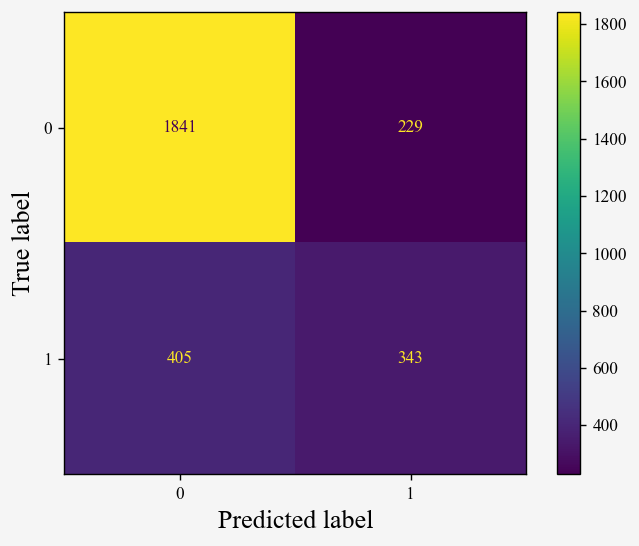

In [43]:
ConfusionMatrixDisplay(cm).plot()